In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.18.0
KerasNLP version: 0.6.4


In [37]:
df_train = pd.read_csv("../Data/train.csv")
df_test = pd.read_csv("../Data/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [38]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [39]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [40]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [41]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [42]:
# stop word removal, from nltk
# stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# from: https://gist.github.com/sebleier/554280
stop_words: set[str] = {
    "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november",
    "december", "0o", "0s", "1-1", "3d", "3a", "3b", "6b", "6o", "10", "39", "'d", "'ll", "'m", "'re", "'s", "'tis",
    "'twas", "'tween", "'tween-decks", "'ve", "a", "a1", "a2", "a3", "a4", "a's", "ab", "aback", "abaft", "abandoned",
    "abandonedly", "abashedly", "abeam", "abed", "abhorrently", "abidingly", "ability", "abiogenetically", "abjectly",
    "ablaze", "able", "ableabout", "ablins", "abloom", "ably", "abnormally", "aboard", "abominably", "aboriginally",
    "aborning", "abortively", "about", "above", "above-board", "abreast", "abroach", "abroad", "abruptly", "absently",
    "absolute", "absolutely", "absorbedly", "absorbingly", "abst", "abstemiously", "abstinently", "abstractedly",
    "abstractively", "abstractly", "abstrusely", "absurdly", "abundantly", "abuse", "abusively", "abysmally", "ac",
    "academic", "academically", "accelerando", "accentually", "acceptable", "acceptably", "acceptedly", "access",
    "accessibly", "accessorily", "accident", "accidentally", "acclaimed", "accommodatingly", "accomplished",
    "accordance", "accordantly", "according", "accordingly", "account", "accountably", "accumulatively", "accurate",
    "accurately", "accursedly", "accusatively", "accusingly", "acervately", "aching", "achingly", "achromatically",
    "acidic", "acidly", "acock", "acoustically", "acquiescently", "acquiescingly", "acquisitively", "acridly",
    "acrimoniously", "acrobatic", "acrobatically", "acrogenously", "acromial", "acropetally", "across",
    "across-the-board", "acrostically", "act", "actinally", "actinically", "action", "actionably", "active", "actively",
    "activity", "actor", "actual", "actually", "actuarially", "acutely", "ad", "ad-lib", "adagio", "adamantly",
    "adaptively", "added", "addition", "additionally", "additively", "address", "adept", "adeptly", "adequately",
    "adhesively", "adiabatically", "adj", "adjacently", "adjectivally", "adjectively", "adjunctively", "adjunctly",
    "adjustably", "administration", "administratively", "admirable", "admirably", "admired", "admiringly", "admissibly",
    "admittedly", "adolescent", "adopted", "adorable", "adorably", "adored", "adoringly", "adown", "adrift", "adroitly",
    "adscititiously", "adult", "adulterously", "adumbratively", "advance", "advanced", "advantage", "advantageously",
    "adventitiously", "adventurous", "adventurously", "adverbially", "adversely", "advertently", "advertising",
    "advice", "advisably", "advisedly", "ae", "aerially", "aerobically", "aerobiologically", "aerobiotically",
    "aerodynamically", "aeronautically", "aesthetic", "aesthetically", "af", "afar", "affably", "affair", "affect",
    "affected", "affectedly", "affecting", "affectingly", "affectionate", "affectionately", "affects", "affettuoso",
    "affirmatively", "affirmingly", "affluently", "affrontingly", "afield", "afire", "aflame", "afloat", "aflutter",
    "afoot", "afore", "aforetime", "afoul", "afraid", "afresh", "aft", "after", "afternoon", "afternoons", "afterward",
    "afterwards", "ag", "again", "against", "agape", "age", "aged", "agency", "agent", "aggravating", "aggravatingly",
    "aggregate", "aggressive", "aggressively", "agile", "agilely", "agitated", "agitatedly", "agitato", "agnatically",
    "ago", "agog", "agone", "agonisingly", "agonistically", "agonizedly", "agonizing", "agonizingly", "agreeable",
    "agreeably", "agreement", "agriculturally", "aground", "aguishly", "ah", "ahead", "ahold", "ahorse", "ahorseback",
    "ai", "aiblins", "aimlessly", "ain", "ain't", "aint", "air", "air-mail", "airily", "airline", "airport", "aj",
    "ajar", "ajee", "akimbo", "al", "alarm", "alarmed", "alarmedly", "alarming", "alarmingly", "alas", "alcohol",
    "alee", "alert", "alertly", "alfresco", "algebraically", "alias", "alienated", "alight", "alike", "aliunde",
    "alive", "all", "all-fired", "all-in", "all-out", "all-over", "allargando", "allegedly", "allegorically",
    "allegretto", "allegro", "allopathically", "allow", "allowably", "allowedly", "allows", "alluringly", "allusively",
    "almighty", "almost", "aloft", "alone", "along", "alongshore", "alongside", "aloof", "aloofly", "aloud", "alow",
    "alphabetically", "alphamerically", "alphanumerically", "already", "alright", "also", "alternately", "alternative",
    "alternatively", "although", "altogether", "altruistic", "altruistically", "alway", "always", "am", "amain",
    "amateurishly", "amatorially", "amazedly", "amazing", "amazingly", "ambidextrously", "ambiguously", "ambition",
    "ambitious", "ambitiously", "ambrosially", "amenably", "amiably", "amicably", "amid", "amidships", "amidst",
    "amiss", "amitotically", "amok", "among", "amongst", "amorally", "amoroso", "amorously", "amorphously", "amoungst",
    "amount", "amphitheatrically", "ample", "amply", "amuck", "amused", "amusedly", "amusing", "amusingly", "an", "ana",
    "anachronically", "anachronistically", "anachronously", "anaerobically", "anaerobiotically", "anagogically",
    "anagrammatically", "anally", "analogically", "analogously", "analysis", "analyst", "analytically",
    "anamnestically", "anarchically", "anarthrously", "anatomically", "ancestrally", "anchored", "ancient", "anciently",
    "and", "andante", "andantino", "anear", "anecdotally", "anemographically", "anes", "anesthetically", "anew",
    "angelic", "angelically", "anger", "angerly", "angle", "angrily", "angry", "anguished", "animal", "animally",
    "animated", "animatedly", "animatingly", "announce", "annoyingly", "annual", "annually", "anomalistically",
    "anomalously", "anon", "anonymously", "another", "answer", "answerably", "antagonistically", "antecedently",
    "anteriorly", "anthropologically", "antichristianly", "anticipatively", "anticipatorily", "anticlimactically",
    "anticlockwise", "antipathetically", "antiphonally", "antiphonically", "antiphrastically", "antique", "antiquely",
    "antiseptically", "antisocially", "antistrophically", "antithetically", "anxiety", "anxious", "anxiously", "any",
    "anybody", "anyhow", "anymore", "anyone", "anyplace", "anything", "anytime", "anyway", "anyways", "anywhere",
    "anywise", "ao", "ap", "apace", "apart", "apartment", "apathetically", "apeak", "aphoristically", "apically",
    "apiece", "apishly", "aplenty", "apocalyptically", "apodeictically", "apodictically", "apogamously",
    "apogeotropically", "apolitically", "apologetically", "apomictically", "apoplectically", "aport", "apostolically",
    "apothegmatically", "appallingly", "apparently", "appassionato", "appeal", "appealingly", "appear", "appearance",
    "appeasingly", "appellatively", "appetizingly", "applaudingly", "apple", "applicably", "application", "appointment",
    "appreciably", "appreciate", "appreciatively", "apprehensive", "apprehensively", "appropriate", "appropriately",
    "approvingly", "approximately", "apropos", "apt", "aptly", "aq", "ar", "arbitrarily", "archaeologically",
    "archaically", "architecturally", "archly", "arco", "arctic", "ardently", "arduously", "are", "area", "areas",
    "aren", "aren't", "arent", "arguably", "argument", "argumentatively", "arid", "aridly", "aright", "arise",
    "aristocratically", "arithmetically", "arm", "army", "aromatic", "around", "around-the-clock", "arpa", "arrantly",
    "arrival", "arrogantly", "arsy-versy", "art", "artfully", "article", "articulately", "artificially", "artistic",
    "artistically", "artlessly", "as", "ascetic", "ascetically", "asexually", "ashamed", "ashamedly", "ashore", "aside",
    "ask", "askance", "asked", "askew", "asking", "asks", "aslant", "asleep", "aslope", "aspect", "aspiringly",
    "asprawl", "asquint", "assai", "assembled", "assentingly", "assertively", "assiduously", "assignment", "assist",
    "assistance", "assistant", "associate", "associated", "association", "assumably", "assumedly", "assumingly",
    "assumption", "assured", "assuredly", "astern", "asthmatically", "astigmatically", "astonishing", "astonishingly",
    "astoundingly", "astraddle", "astray", "astride", "astringently", "astrologically", "astronomically", "astuciously",
    "astutely", "asunder", "asymmetrically", "asymptomatically", "asymptotically", "asynchronously", "at", "at-home",
    "atheistically", "athletic", "athletically", "athwart", "atilt", "atmosphere", "atmospherically", "atomistically",
    "atoningly", "atop", "atremble", "atrociously", "attached", "attack", "attempt", "attention", "attentive",
    "attentively", "attitude", "attractingly", "attractive", "attractively", "attributively", "atwain", "atweel",
    "atypically", "au", "audaciously", "audibly", "audience", "aught", "augustly", "aurally", "auricularly",
    "aurorally", "auspiciously", "austere", "austerely", "auth", "authentic", "authentically", "author",
    "authoritatively", "authorized", "autobiographically", "autocratically", "autodidactically", "autographically",
    "automatic", "automatically", "automorphically", "autonomously", "autumnally", "av", "ava", "available",
    "availably", "availingly", "avaricious", "avariciously", "average", "aversely", "avertedly", "avidly", "avoidably",
    "avowedly", "aw", "awa", "award", "aware", "awareness", "awash", "away", "awesome", "awesomely", "awful", "awfully",
    "awheel", "awhile", "awkward", "awkwardly", "awry", "ax", "axially", "axiomatically", "ay", "az", "b", "b1", "b2",
    "b3", "ba", "baby", "babyish", "back", "backed", "background", "backhand", "backhanded", "backing", "backs",
    "backstage", "backward", "backwardly", "backwards", "bad", "badly", "bafflingly", "bag", "baggily", "baggy", "bake",
    "balance", "baldly", "balefully", "balkingly", "ball", "balletically", "bally", "balmily", "banally", "band",
    "banefully", "bang", "bank", "banteringly", "baptismally", "bar", "barbarously", "bare", "bareback", "barebacked",
    "barefacedly", "barefoot", "barefooted", "barehanded", "bareheaded", "bareknuckle", "barelegged", "barely",
    "baresark", "barometrically", "barratrously", "barren", "base", "baseball", "basely", "bashfully", "basic",
    "basically", "basis", "basket", "bat", "bath", "bathroom", "battle", "bawdily", "bb", "bc", "bd", "be", "beach",
    "beadily", "beamily", "beamingly", "bear", "bearably", "bearishly", "beastly", "beat", "beatifically",
    "beauteously", "beautiful", "beautifully", "became", "because", "become", "becomes", "becoming", "becomingly",
    "bed", "bedroom", "bedward", "been", "beer", "befittingly", "before", "beforehand", "beforetime", "began",
    "begetter", "begin", "beginning", "beginnings", "begins", "begrudgingly", "behaviorally", "behind", "being",
    "beings", "belated", "belatedly", "believably", "believe", "believingly", "belike", "belive", "bell", "bellicosely",
    "belligerently", "beloved", "below", "belt", "ben", "bench", "bend", "bene", "beneath", "beneficently",
    "beneficial", "beneficially", "benefit", "benevolently", "benignantly", "benignly", "beseechingly", "beside",
    "besides", "besiegingly", "besottedly", "best", "bestially", "bet", "betimes", "better", "between", "between-decks",
    "betweentimes", "betweenwhiles", "betwixt", "bewilderingly", "bewitched", "bewitchingly", "beyond", "bf", "bg",
    "bh", "bi", "biannually", "bias", "biblically", "bibliographically", "bibulously", "bicycle", "bid", "biennially",
    "bifariously", "big", "big-hearted", "bigamously", "bike", "bilaterally", "bilingually", "biliously", "bill",
    "billion", "bimanually", "bimonthly", "binaurally", "binocularly", "biochemically", "biodegradable",
    "biographically", "biol", "biologically", "bird", "birth", "birthday", "bis", "bisexually", "bit", "bite",
    "bite-sized", "bitingly", "bitter", "bitterly", "biyearly", "bizarrely", "bj", "bk", "bl", "black",
    "black-and-white", "blackguardly", "blackly", "blamably", "blame", "blameably", "blamed", "blamefully",
    "blamelessly", "bland", "blandly", "blank", "blankety", "blankety-blank", "blankly", "blaring", "blasphemously",
    "blasted", "blatantly", "bleak", "bleakly", "blearily", "bleeding", "blessedly", "blind", "blindfold", "blindingly",
    "blindly", "blinking", "blissful", "blissfully", "blisteringly", "blithely", "blithesomely", "block", "blond",
    "blood", "bloodily", "bloodlessly", "bloodthirstily", "bloody", "blooming", "blow", "blue", "bluely", "bluffly",
    "blunderingly", "bluntly", "blushing", "blushingly", "blusteringly", "bm", "bn", "bo", "board", "boastfully",
    "boat", "bodily", "body", "bogus", "boiling", "boisterously", "bold", "boldly", "bolt", "bombastically", "bone",
    "bonnily", "bonny", "bonus", "bony", "book", "boorishly", "boot", "bootlessly", "boozily", "border", "boring",
    "boringly", "boss", "bossy", "botanically", "both", "bother", "bottle", "bottom", "bouncy", "boundlessly",
    "bounteously", "bountiful", "bountifully", "bovinely", "bowed", "bowl", "box", "boy", "boyfriend", "boyishly", "bp",
    "br", "braggartly", "braggingly", "brain", "brainlessly", "brainsickly", "branch", "brashly", "brassily", "brave",
    "bravely", "brawly", "brazenly", "bread", "breadthways", "breadthwise", "break", "breakable", "breakfast", "breast",
    "breast-deep", "breast-high", "breath", "breathlessly", "breezily", "brick", "bridge", "brief", "briefly", "bright",
    "brightly", "brilliant", "brilliantly", "brisk", "briskly", "broad", "broad-mindedly", "broadcast", "broadly",
    "broadside", "broadwise", "broken", "brokenly", "bronchoscopically", "bronze", "brother", "brotherly", "brown",
    "bruised", "brush", "brusquely", "brutally", "brutishly", "bs", "bt", "bu", "bubbly", "buckishly", "bucolically",
    "buddy", "budget", "bug", "building", "bulgingly", "bulkily", "bulky", "bullishly", "bumpily", "bumptiously",
    "bumpy", "bunch", "bunglingly", "buoyant", "buoyantly", "burdensome", "bureaucratically", "burglariously", "burly",
    "burn", "burningly", "bus", "bushily", "busily", "business", "bustling", "busy", "but", "buttery", "button", "buy",
    "buyer", "buzzing", "buzzingly", "bv", "bw", "bx", "by", "by-and-by", "Byronically", "bz", "c", "c1", "c2", "c3",
    "c'mere", "c'mon", "c's", "ca", "cabinet", "cable", "cagily", "cajolingly", "cake", "calamitously", "calculably",
    "calculating", "calculatingly", "calendar", "call", "called", "calligraphy", "callously", "calm", "calmly",
    "calumniously", "came", "camera", "camp", "campaign", "can", "can't", "cancel", "cancer", "candid", "candidate",
    "candidly", "candle", "candy", "canine", "cankeredly", "cannibally", "cannily", "cannot", "canny", "canonically",
    "canorously", "cant", "cantabile", "cantankerously", "cap", "cap-a-pie", "capably", "capaciously", "capital",
    "capitally", "capitularly", "capriccioso", "capriciously", "caption", "captiously", "car", "card", "cardinally",
    "care", "career", "carefree", "careful", "carefully", "careless", "carelessly", "caressingly", "caring", "carnally",
    "carnivorously", "carousingly", "carpet", "carpingly", "carry", "case", "cases", "cash", "cash-and-carry",
    "casually", "casuistically", "cat", "catachrestically", "cataclysmically", "catalytically", "catastrophically",
    "catch", "catch-as-catch-can", "catechetically", "catechumenically", "categorically", "category", "cattily",
    "cattishly", "caudad", "caudally", "causally", "causatively", "cause", "causelessly", "causes", "caustically",
    "cautious", "cautiously", "cavalierly", "cavernous", "cavernously", "cc", "cd", "ce", "ceaselessly", "celebrated",
    "celebration", "celestially", "cell", "censoriously", "censurably", "centennially", "centesimally", "centrally",
    "centrically", "centrifugally", "centripetally", "cephalad", "ceremonially", "ceremoniously", "certain",
    "certainly", "certes", "certifiably", "cf", "cg", "ch", "chaffingly", "chain", "chair", "challenge",
    "challengingly", "champion", "championship", "chance", "change", "changeably", "changefully", "changes", "channel",
    "chaotically", "chapter", "character", "characteristically", "charge", "chargeably", "charily", "charitably",
    "charity", "charming", "charmingly", "charmlessly", "chart", "chastely", "chattily", "chauvinistically", "cheap",
    "cheaply", "check", "cheek", "cheekily", "cheerful", "cheerfully", "cheerily", "cheerlessly", "cheerly", "cheery",
    "chemical", "chemically", "chemistry", "cherubically", "chest", "chicken", "chicly", "chidingly", "chief",
    "chiefly", "child", "childhood", "childishly", "chillingly", "chilly", "chimerically", "chip", "chirpily",
    "chivalrously", "chock", "chock-a-block", "chocolate", "choice", "choicely", "cholerically", "chop-chop",
    "choppily", "chorally", "Christian", "Christianly", "chromatically", "chronically", "chronologically", "chubby",
    "chummily", "church", "churchward", "churlishly", "ci", "cigarette", "circuitously", "circular", "circularly",
    "circumspectly", "circumstantially", "cit", "city", "civically", "civilly", "cj", "ck", "cl", "claim", "clamantly",
    "clammily", "clamorously", "clandestinely", "clangorously", "clannishly", "class", "classic", "classically",
    "classroom", "clatteringly", "clean", "cleanly", "clear", "clear-cut", "clearly", "clemently", "clerically",
    "clerk", "clerkly", "clever", "cleverly", "click", "client", "climactically", "climate", "climatically",
    "clinically", "cliquishly", "clock", "clockwise", "close", "close-up", "closed", "closely", "closer", "closest",
    "closet", "clothes", "cloud", "cloudily", "cloudlessly", "cloudy", "clownishly", "club", "clue", "clueless",
    "clumsily", "clumsy", "cluttered", "cm", "cmon", "cn", "co", "co.", "coach", "coarse", "coarsely", "coast",
    "coastward", "coastwise", "coat", "coaxingly", "cockily", "cod", "code", "coequally", "coercively", "coevally",
    "coffee", "cogently", "cognisably", "cognitively", "cognizably", "coherently", "cohesively", "coincidentally",
    "coincidently", "cold", "cold-bloodedly", "coldly", "collar", "collaterally", "collect", "collectedly",
    "collection", "collectively", "college", "colloquially", "collusively", "colonially", "colorful", "colorless",
    "colossal", "colossally", "colourably", "com", "combatively", "combination", "combine", "come", "comes", "comfort",
    "comfortable", "comfortably", "comfortingly", "comically", "command", "commandingly", "commendable", "commendably",
    "commensally", "commensurably", "commensurately", "comment", "commercial", "commercially", "commission",
    "committee", "commodiously", "common", "commonly", "communally", "communicably", "communication", "communicatively",
    "community", "commutatively", "compactedly", "compactly", "companionably", "company", "comparably", "comparatively",
    "comparison", "compartmentally", "compassionate", "compassionately", "compatibly", "compendiously", "competent",
    "competently", "competition", "competitively", "complacently", "complainingly", "complaint", "complaisantly",
    "complete", "completely", "complex", "complexly", "compliantly", "complicated", "complicatedly", "composed",
    "composedly", "compositely", "comprehensibly", "comprehensively", "compulsively", "compulsorily", "compunctiously",
    "computer", "con", "concavely", "conceitedly", "conceivably", "concentrate", "concentrically", "concept",
    "conceptually", "concern", "concerned", "concernedly", "concerning", "concert", "concertedly", "concisely",
    "conclusion", "conclusively", "concomitantly", "concordantly", "concrete", "concretely", "concurrently",
    "condescendingly", "condignly", "condition", "conditionally", "conducingly", "confer", "conference", "confessedly",
    "confidence", "confidentially", "confidently", "confidingly", "conflict", "conformably", "confoundedly",
    "confoundingly", "confused", "confusedly", "confusingly", "confusion", "congenially", "congenitally", "congruently",
    "congruously", "conically", "conjecturally", "conjointly", "conjugally", "conjunctionally", "conjunctively",
    "conjunctly", "connaturally", "connectedly", "connection", "connectively", "connubial", "connubially",
    "conqueringly", "conscientiously", "conscionably", "conscious", "consciously", "consecutive", "consecutively",
    "consensually", "consentaneously", "consequence", "consequentially", "consequently", "conservatively", "consider",
    "considerably", "considerate", "considerately", "consideration", "considering", "consist", "consistently",
    "consolingly", "consonantly", "conspicuously", "conspiratorially", "conspiringly", "constant", "constantly",
    "constitutionally", "constrainedly", "construction", "constructively", "consubstantially", "consumedly",
    "consummately", "consumptively", "contact", "contagiously", "contain", "containing", "contains", "contemplatively",
    "contemporaneously", "contemptibly", "contemptuously", "content", "contentedly", "contentiously", "contently",
    "conterminously", "contest", "contestingly", "context", "contextually", "contiguously", "continently",
    "contingently", "continually", "continuedly", "continuously", "contra", "contract", "contractedly", "contractually",
    "contradictiously", "contradictively", "contradictorily", "contrapuntally", "contrarily", "contrariously",
    "contrariwise", "contrary", "contrastingly", "contribution", "contritely", "control", "controversially",
    "controvertibly", "contumaciously", "contumeliously", "conveniently", "conventional", "conventionally",
    "conversably", "conversation", "conversationally", "conversely", "convert", "convertibly", "convexedly", "convexly",
    "convincingly", "convivially", "convulsively", "cooingly", "cook", "cooked", "cookie", "cool", "coolly",
    "cooperative", "cooperatively", "coordinated", "coordinately", "copiously", "copy", "coquettishly", "cordially",
    "corner", "cornerwise", "corny", "corporally", "corporately", "corporeally", "corpulently", "correctly",
    "correlatively", "correspondently", "corresponding", "correspondingly", "corrosively", "corrupt", "corruptibly",
    "corruptly", "cosily", "cosmetically", "cosmically", "cost", "costively", "costly", "could", "could've", "couldn",
    "couldn't", "couldnt", "count", "counter", "counteractively", "counterclockwise", "counterfeitly", "country",
    "county", "couple", "courage", "courageous", "courageously", "course", "court", "courteous", "courteously",
    "cousin", "cousinly", "cover", "covertly", "covetingly", "covetously", "cow", "coweringly", "coxcombically",
    "coyly", "cozily", "cp", "cq", "cr", "crabbedly", "crabwise", "crack", "cracking", "craft", "craftily", "crafty",
    "crankily", "crash", "crassly", "cravenly", "crazily", "crazy", "creakily", "cream", "creamily", "creamy",
    "creative", "creatively", "credibly", "credit", "creditably", "credulously", "creepily", "creepingly", "creepy",
    "crescendo", "crew", "criminal", "criminally", "cringingly", "crisp", "crispily", "crisply", "crisscross",
    "critical", "critically", "criticism", "croakily", "crooked", "crookedly", "cross", "cross-country", "cross-legged",
    "crossly", "crosstown", "crossways", "crosswise", "crousely", "crowded", "crucially", "crudely", "cruel", "cruelly",
    "crushing", "crushingly", "crustily", "cry", "cryptically", "cryptography", "cs", "ct", "cu", "cubically",
    "cubistically", "cuddly", "culpably", "cultivated", "culturally", "culture", "cultured", "cumbersome", "cumbrously",
    "cumulatively", "cunningly", "cup", "curiously", "curly", "currency", "current", "currently", "currishly",
    "cursedly", "cursively", "cursorily", "curtly", "curve", "curvy", "cussedly", "customarily", "customer", "cut",
    "cute", "cutely", "cuttingly", "cv", "cx", "cy", "cycle", "cyclically", "cylindrical", "cylindrically", "cynically",
    "cytogenetically", "cz", "d", "d2", "d'accord", "da", "dactylically", "dad", "daftly", "daily", "daintily", "dam",
    "damage", "damaged", "damagingly", "damn", "damnably", "damned", "damp", "damply", "dance", "dandily", "dang",
    "dangerous", "dangerously", "dankly", "dapper", "dapperly", "dare", "daren't", "darent", "daring", "daringly",
    "dark", "darkling", "darkly", "darling", "darn", "darned", "dartingly", "dash", "dashed", "dashingly", "data",
    "database", "date", "daughter", "dauntingly", "dauntlessly", "dawdlingly", "day", "daylong", "days", "dazedly",
    "dazzling", "dazzlingly", "dc", "dd", "de", "dead", "dead-set", "deadly", "deafening", "deafeningly", "deafly",
    "deal", "dealer", "dear", "dearest", "dearly", "death", "deathlessly", "deathly", "deathy", "debasingly", "debate",
    "debatingly", "debauchedly", "debonairly", "debt", "decadently", "decani", "deceitfully", "deceivably",
    "deceivingly", "decent", "decently", "deceptively", "decidedly", "decimal", "decimally", "decision", "decisive",
    "decisively", "declaratively", "declaredly", "decorative", "decoratively", "decorously", "decreasingly",
    "decumbently", "decurrently", "decussately", "deductively", "deep", "deeply", "defectively", "defencelessly",
    "defenseless", "defenselessly", "defensibly", "defensive", "defensively", "deferentially", "defiant", "defiantly",
    "deficient", "deficiently", "definably", "definite", "definitely", "definition", "definitive", "definitively",
    "deformedly", "deftly", "degenerately", "degree", "deictically", "deistically", "dejectedly", "delay", "delayed",
    "delayingly", "delectable", "delectably", "deleteriously", "deliberately", "deliberatively", "delicately",
    "delicious", "deliciously", "delightedly", "delightful", "delightfully", "delinquently", "delirious", "deliriously",
    "deliverly", "delivery", "delusively", "demand", "demanding", "dementedly", "demiurgically", "democratically",
    "demographically", "demoniacally", "demonstrably", "demonstratively", "demurely", "denominationally",
    "denominatively", "denotatively", "dense", "densely", "dental", "denumerably", "department", "departmentally",
    "departure", "dependable", "dependably", "dependent", "dependently", "deplorably", "deploringly", "deposit",
    "depravedly", "depravingly", "deprecatingly", "deprecatorily", "depreciatingly", "depressingly", "depression",
    "depth", "deridingly", "derisively", "derivatively", "dern", "derogatively", "derogatorily", "describe",
    "described", "description", "descriptive", "descriptively", "deserted", "deservedly", "deservingly", "design",
    "designedly", "designer", "designingly", "desirably", "desire", "desirously", "desk", "desolately", "despairingly",
    "desperately", "despicably", "despite", "despitefully", "despondently", "despondingly", "despotically",
    "destructively", "desultorily", "detachedly", "detail", "detailed", "determinably", "determined", "determinedly",
    "detestably", "detractingly", "detractively", "detrimentally", "deuced", "deucedly", "development", "developmental",
    "developmentally", "device", "devil", "devilish", "devilishly", "deviously", "devoted", "devotedly", "devotionally",
    "devouringly", "devoutly", "dewily", "dexterously", "dextrally", "dextrously", "df", "di", "diabolically",
    "diagnostically", "diagonally", "diagrammatically", "dialectally", "dialectically", "diamagnetically",
    "diametrally", "diametrically", "diamond", "diaphanously", "diatonically", "dichotomously", "dictatorially", "did",
    "didactically", "didn", "didn't", "didnt", "diet", "differ", "difference", "different", "differentially",
    "differently", "difficult", "difficultly", "difficulty", "diffidently", "diffusedly", "diffusely", "diffusively",
    "dig", "digestedly", "digestively", "digital", "digitally", "digitately", "digressively", "dilatorily", "diligent",
    "diligently", "dim", "dimension", "diminishingly", "diminutively", "dimly", "dimpled", "dimwitted", "dingily",
    "dinner", "diplomatically", "direct", "direction", "directly", "director", "direfully", "direly", "dirt",
    "dirt-cheap", "dirtily", "dirty", "disadvantageously", "disaffectedly", "disagreeably", "disappointedly",
    "disappointingly", "disapprovingly", "disarmingly", "disaster", "disastrous", "disastrously", "disbelievingly",
    "discernibly", "discerningly", "discipline", "discommodiously", "disconcertingly", "disconnectedly",
    "disconsolately", "discontentedly", "discontinuously", "discordantly", "discount", "discouragingly",
    "discourteously", "discreditably", "discreetly", "discrete", "discretely", "discretionally", "discretionarily",
    "discriminately", "discriminatingly", "discriminatively", "discursively", "discussion", "disdainfully", "disease",
    "disfigured", "disgracefully", "disguised", "disguisedly", "disgustedly", "disgustfully", "disgusting",
    "disgustingly", "dish", "dishearteningly", "dishonest", "dishonestly", "dishonorably", "dishonourably",
    "disingenuously", "disinterestedly", "disjointedly", "disjunctively", "disk", "disloyal", "disloyally", "dismal",
    "dismally", "disobediently", "disobligingly", "disorderly", "disparagingly", "disparately", "dispassionately",
    "dispensatorily", "dispersedly", "dispiritedly", "dispiteously", "display", "displeasingly", "disposedly",
    "disposingly", "dispraisingly", "disproportionably", "disproportionally", "disproportionately", "disputably",
    "disputatiously", "disquietingly", "disquietly", "disregardfully", "disregarding", "disreputably",
    "disrespectfully", "disruptively", "dissemblingly", "dissentingly", "dissimilarly", "dissipatedly", "dissolutely",
    "dissolutive", "dissonantly", "dissuasively", "dissymmetrically", "distally", "distance", "distant", "distantly",
    "distastefully", "distinct", "distinctively", "distinctly", "distinguishably", "distorted", "distractedly",
    "distractingly", "distractively", "distressfully", "distressingly", "distribution", "distributively", "district",
    "distrustfully", "disturbingly", "dithyrambically", "ditto", "diurnally", "divergently", "diversely", "divertingly",
    "divide", "dividedly", "divinely", "divisibly", "divisively", "dizzily", "dizzy", "dj", "dk", "dl", "dm", "do",
    "docilely", "doctor", "doctrinally", "document", "documentarily", "does", "doesn", "doesn't", "doesnt", "dog",
    "dog-cheap", "doggedly", "doggishly", "doggo", "doggone", "dogmatically", "doing", "dolce", "dolefully", "doloroso",
    "dolorously", "doltishly", "domestically", "dominantly", "domineeringly", "don", "don't", "done", "dont", "dooms",
    "door", "door-to-door", "dopey", "dorsally", "dot", "doting", "dotingly", "double", "double-quick", "doubly",
    "doubt", "doubtful", "doubtfully", "doubtingly", "doubtless", "doucely", "doughtily", "dourly", "dowdily", "down",
    "down-the-line", "downed", "downheartedly", "downhill", "downing", "downrange", "downright", "downriver", "downs",
    "downstage", "downstairs", "downstate", "downstream", "downward", "downwardly", "downwards", "downwind", "dp", "dr",
    "drab", "drably", "draft", "draftily", "drafty", "drag", "drama", "dramatic", "dramatically", "drastically", "draw",
    "drawer", "drawing", "drawlingly", "dreadfully", "dream", "dreamily", "dreamingly", "dreamlessly", "drearily",
    "dreary", "dress", "dressily", "drily", "drink", "dripping", "drive", "driver", "drizzly", "drolly", "droningly",
    "droopingly", "droopy", "drop", "drowsily", "drudgingly", "drunk", "drunkenly", "dry", "dryer", "dryly", "ds", "dt",
    "du", "dual", "dualistically", "dually", "dubiously", "dubitably", "dubitatively", "ducally", "due", "dull",
    "dully", "duly", "dumbly", "dump", "dumpishly", "durably", "during", "duskily", "dust", "dustily", "duteously",
    "dutiful", "dutifully", "duty", "duty-free", "dwarfishly", "dx", "dy", "dynamically", "dynastically",
    "dyslogistically", "dyspeptically", "dz", "e", "e2", "e3", "e'er", "ea", "each", "eager", "eagerly", "ear",
    "earlier", "earliest", "early", "earnest", "earnestly", "earth", "earthward", "earthwards", "ease", "easily",
    "east", "east-by-north", "easterly", "eastward", "eastwardly", "eastwards", "easy", "easy-going", "eat", "eath",
    "ebulliently", "ec", "eccentrically", "ecclesiastically", "eclectically", "ecologically", "economically",
    "economics", "economy", "ecstatic", "ecstatically", "ecumenically", "ed", "edge", "edgeways", "edgewise", "edgily",
    "edible", "edictally", "edifyingly", "editor", "editorially", "edu", "educated", "education", "educationally", "ee",
    "eerily", "ef", "effect", "effective", "effectively", "effectually", "effeminately", "effervescently",
    "effervescingly", "effetely", "efficaciously", "efficiency", "efficiently", "effort", "effortlessly", "effulgently",
    "effusively", "eft", "eftsoons", "eg", "egg", "egoistically", "egotistically", "egregiously", "eh", "ei", "eight",
    "eightfold", "eighth", "eighthly", "eighty", "either", "ej", "el", "elaborate", "elaborately", "elastic",
    "elastically", "elated", "elatedly", "elderly", "election", "electively", "electric", "electrically",
    "electrolytically", "electrometrically", "electronically", "electrostatically", "elegant", "elegantly",
    "elementally", "elementarily", "elementary", "elevator", "eleven", "eligibly", "elliptical", "elliptically",
    "eloquently", "else", "elsewhere", "elsewhither", "elusively", "em", "embarrassed", "embarrassingly", "embellished",
    "emblematically", "emergency", "emergently", "eminent", "eminently", "emotion", "emotional", "emotionally",
    "emphasis", "emphatically", "empirically", "employ", "employee", "employer", "employment", "emptily", "empty",
    "emulously", "en", "enchanted", "enchanting", "enchantingly", "enclitically", "encomiastically", "encouragingly",
    "end", "end-on", "endearingly", "ended", "endemic", "endemically", "ending", "endlessly", "endlong",
    "endosmotically", "ends", "endurably", "enduringly", "endways", "endwise", "energetic", "energetically", "energy",
    "enforcedly", "engagingly", "engine", "engineer", "engineering", "enharmonically", "enigmatically", "enjoyably",
    "enlargedly", "enlightened", "enormous", "enormously", "enough", "enow", "enraged", "ensemble", "enterprisingly",
    "entertainingly", "entertainment", "enthusiasm", "enthusiastically", "enticingly", "entire", "entirely",
    "entomologically", "entrance", "entreatingly", "entry", "enviably", "envious", "enviously", "environment",
    "environmentally", "envyingly", "eo", "ep", "epexegetically", "ephemerally", "epidemically", "epigrammatically",
    "episodically", "eq", "equably", "equal", "equally", "equanimously", "equatorial", "equatorially", "equidistantly",
    "equipment", "equitably", "equivalent", "equivalently", "equivocally", "er", "erectly", "erelong", "erenow",
    "erewhile", "ergo", "erotically", "errantly", "erratically", "erringly", "erroneously", "error", "erst",
    "erstwhile", "eruditely", "es", "escape", "esoterically", "especially", "essay", "essential", "essentially", "est",
    "establishment", "estate", "esteemed", "esthetically", "estimably", "estimate", "esuriently", "et", "et-al", "etc",
    "eternally", "ethereally", "ethical", "ethically", "ethnically", "ethnocentrically", "ethnologically",
    "ethologically", "etymologically", "eu", "eugenically", "euhemeristically", "eulogistically", "euphemistically",
    "euphoniously", "euphoric", "euphuistically", "ev", "evanescently", "evangelically", "evasively", "even",
    "even-handedly", "evening", "evenings", "evenly", "evens", "event", "eventfully", "eventually", "ever", "evergreen",
    "everlasting", "everlastingly", "evermore", "every", "everybody", "everyone", "everyplace", "everything",
    "everyway", "everywhen", "everywhere", "evidence", "evidentially", "evidently", "evil", "evil-mindedly", "evilly",
    "evocatively", "ex", "exactingly", "exactly", "exaggeratedly", "exalted", "exaltedly", "exam", "examination",
    "example", "exceeding", "exceedingly", "excellent", "excellently", "excelsior", "except", "exceptionably",
    "exceptionally", "excessively", "exchange", "exchangeably", "excitable", "excitably", "excited", "excitedly",
    "excitement", "exciting", "excitingly", "exclusively", "excruciatingly", "excursively", "excusably", "excuse",
    "execrably", "execratively", "executively", "exegetically", "exemplarily", "exemplary", "exercise", "exhausted",
    "exhaustively", "exhibitively", "exhilaratingly", "exigently", "exiguously", "eximiously", "existentially", "exit",
    "exorbitantly", "exoterically", "exothermally", "exothermically", "exotic", "exotically", "expansively",
    "expectably", "expectantly", "expectingly", "expediently", "expeditiously", "expensive", "expensively",
    "experience", "experienced", "experientially", "experimentally", "expert", "expertly", "explanation",
    "explanatorily", "explicitly", "explosively", "exponentially", "express", "expression", "expressionlessly",
    "expressively", "expressly", "exquisitely", "extemporaneously", "extemporarily", "extempore", "extendedly",
    "extension", "extensionally", "extensively", "extent", "extenuatingly", "exteriorly", "external", "externally",
    "extorsively", "extortionately", "extra", "extra-large", "extra-small", "extraneous", "extraneously",
    "extraordinarily", "extravagantly", "extreme", "extremely", "extrinsically", "extroverted", "exuberantly",
    "exultantly", "exultingly", "ey", "eye", "f", "f2", "fa", "fabulous", "fabulously", "face", "faces", "facetiously",
    "facially", "facilely", "fact", "factiously", "factitiously", "factor", "facts", "factually", "facultatively",
    "fadedly", "fadelessly", "fail", "failing", "failure", "fain", "faint", "faintly", "fair", "fairily", "fairly",
    "faithful", "faithfully", "faithlessly", "fake", "fall", "fallaciously", "fallalishly", "fallibly", "false",
    "falsely", "falteringly", "familiar", "familiarly", "family", "famous", "famously", "fan", "fanatically",
    "fancifully", "fancy", "fantastic", "fantastically", "fanwise", "far", "far-flung", "far-forth", "far-off",
    "faraway", "farcically", "farm", "farmer", "farther", "farthest", "fascinatingly", "fashionably", "fast", "faster",
    "fastest", "fastidiously", "fat", "fatal", "fatalistically", "fatally", "fatefully", "father", "fatherly",
    "fatidically", "fatly", "fatuously", "fault", "faultily", "faultlessly", "favorable", "favorably", "favorite",
    "favourably", "fawningly", "fc", "fear", "fearful", "fearfully", "fearless", "fearlessly", "fearsomely", "feasible",
    "feasibly", "featly", "feature", "fecklessly", "feckly", "federally", "fee", "feeble-mindedly", "feebly", "feed",
    "feedback", "feel", "feeling", "feelingly", "feignedly", "feisty", "felicitously", "feline", "felly", "feloniously",
    "felt", "female", "feminine", "femininely", "fermentation", "ferociously", "fertilely", "fervently", "fervidly",
    "festally", "festinately", "festively", "fetchingly", "feudally", "feverishly", "few", "fewer", "ff", "fi",
    "fickle", "fictionally", "fictitiously", "fiducially", "field", "fiendishly", "fiercely", "fierily", "fifteen",
    "fifth", "fifthly", "fifty", "fifty-fifty", "fify", "fight", "figuratively", "figure", "filchingly", "file",
    "filially", "fill", "film", "filthily", "filthy", "final", "finally", "finance", "financially", "find", "finding",
    "finds", "fine", "fined", "finely", "finest", "finger", "finically", "finish", "finished", "finitely", "fire",
    "firm", "firmly", "first", "first-class", "first-hand", "first-rate", "firsthand", "firstly", "fiscally", "fish",
    "fishily", "fishing", "fissiparously", "fitfully", "fitly", "fitting", "fittingly", "five", "fivefold", "fix",
    "fixed", "fixedly", "fj", "fk", "fl", "flabbily", "flaccidly", "flagitiously", "flagrantly", "flaky", "flamboyant",
    "flamboyantly", "flamingly", "flaringly", "flashily", "flashy", "flat", "flatling", "flatly", "flatteringly",
    "flatulently", "flatways", "flatwise", "flauntingly", "flawed", "flawless", "flawlessly", "fleeringly", "fleetly",
    "flexibly", "flickering", "flickeringly", "flight", "flightily", "flimsily", "flimsy", "flinchingly", "flintily",
    "flip-flap", "flip-flop", "flippant", "flippantly", "flipping", "flirtatiously", "flirtingly", "floatingly",
    "floor", "flop", "floppily", "florally", "floridly", "floristically", "flourishingly", "floutingly", "flow",
    "flower", "flowery", "flowingly", "fluently", "fluffy", "fluid", "fluidly", "flush", "flustered", "fly", "flying",
    "fm", "fn", "fo", "foamily", "foamingly", "focally", "focus", "focused", "foggily", "fold", "followed", "following",
    "follows", "fond", "fondly", "food", "foolhardily", "foolhardy", "foolish", "foolishly", "foot", "football",
    "foppishly", "for", "forbearingly", "forbiddenly", "forbiddingly", "forby", "force", "forcedly", "forceful",
    "forcefully", "forcibly", "fore", "forebodingly", "forehand", "forehanded", "foreknowingly", "foremost",
    "forensically", "forever", "forevermore", "forgetfully", "forgivably", "forgivingly", "forked", "forkedly",
    "forlornly", "form", "formal", "formally", "former", "formerly", "formidably", "formlessly", "forrad", "forrader",
    "forsaken", "forsakenly", "forsooth", "forte", "forth", "forthright", "forthrightly", "forthwith", "fortissimo",
    "fortnightly", "fortuitously", "fortunate", "fortunately", "fortune", "forty", "forward", "forwardly", "forwards",
    "forwhy", "forzando", "foul", "foully", "found", "foundation", "four", "fourfold", "foursquare", "fourth",
    "fourth-class", "fourthly", "foxily", "fr", "fractionally", "fractiously", "fragilely", "fragmentarily",
    "fragmentary", "fragrant", "fragrantly", "frail", "frailly", "frame", "frank", "frankly", "frantically",
    "franticly", "fraternally", "fraudfully", "fraudulently", "frayed", "freakishly", "free", "free-hand", "freedom",
    "freely", "freest", "French", "frenetically", "frenziedly", "frequent", "frequently", "fresh", "freshly",
    "fretfully", "Fridays", "friend", "friendly", "friendship", "frightened", "frightening", "frighteningly",
    "frightfully", "frigid", "frigidly", "frilly", "friskily", "friskingly", "frivolous", "frivolously", "frizzy",
    "fro", "frolicsomely", "from", "front", "frontally", "frontlessly", "frontward", "frontwards", "frostily", "frosty",
    "frothily", "frowardly", "frowningly", "frozen", "frugal", "frugally", "fruit", "fruitful", "fruitfully",
    "fruitlessly", "frumpily", "frumpishly", "fs", "ft", "fu", "fuel", "fugally", "fugato", "fugitively", "fulgently",
    "fuliginously", "full", "full-faced", "full-sail", "full-time", "fully", "fulsomely", "fumbling", "fumblingly",
    "fun", "function", "functional", "functionally", "fundamentally", "funeral", "funereally", "funnily", "funny",
    "furioso", "furiously", "further", "furthered", "furthering", "furthermore", "furthers", "furthest", "furtively",
    "fussily", "fussy", "fustily", "futilely", "future", "fuzzily", "fuzzy", "fx", "fy", "g", "ga", "gaily", "gain",
    "gainfully", "gainly", "gallantly", "galley-west", "Gallice", "gallingly", "galvanically", "game", "gamely", "gap",
    "gapingly", "garage", "garbage", "garden", "gargantuan", "garishly", "garrulously", "gas", "gaseous", "gaspingly",
    "gastronomically", "gate", "gather", "gauchely", "gaudily", "gauntly", "gave", "gawkily", "gb", "gd", "ge", "gear",
    "gelidly", "gene", "genealogically", "general", "generally", "generically", "generous", "generously", "genetically",
    "genially", "geniculately", "genitivally", "genotypically", "genteelly", "gentle", "gently", "genuine", "genuinely",
    "geocentrically", "geodetically", "geognostically", "geographically", "geologically", "geometrically",
    "geopolitically", "geotactically", "geotropically", "germanely", "Germanically", "get", "gets", "getting", "gey",
    "gf", "gg", "gh", "ghastfully", "ghastly", "ghoulishly", "gi", "giant", "gibbously", "gibingly", "giddily", "giddy",
    "gift", "gifted", "giftedly", "gigantic", "gigantically", "gingerly", "giocoso", "girl", "girlfriend", "girlishly",
    "giusto", "give", "given", "gives", "giving", "gj", "gl", "glacially", "glad", "gladly", "gladsomely", "glamorous",
    "glamorously", "glancingly", "glandularly", "glaring", "glaringly", "glass", "glassily", "gleaming", "gleeful",
    "gleefully", "glibly", "glidingly", "glimmeringly", "glissando", "glistening", "glisteringly", "glittering",
    "glitteringly", "gloatingly", "globally", "globularly", "gloomily", "gloomy", "glorious", "gloriously",
    "glossarially", "glossily", "glossy", "glove", "gloweringly", "glowingly", "glum", "glumly", "glutinously",
    "gluttonously", "gm", "gmt", "gn", "gnashingly", "gnathonically", "gnostically", "go", "goal", "god", "goddam",
    "goddamn", "goddamned", "godlessly", "goes", "going", "gold", "goldarn", "golden", "goldenly", "golf", "gone",
    "goniometrically", "good", "good-humouredly", "good-natured", "good-naturedly", "goods", "goofily", "gorgeous",
    "gorgeously", "gorily", "got", "gotten", "gov", "government", "gp", "gq", "gr", "grab", "graceful", "gracefully",
    "gracelessly", "gracious", "graciously", "gradatim", "gradationally", "grade", "gradually", "grammatically",
    "gramophonically", "grand", "grandfather", "grandiloquently", "grandiose", "grandiosely", "grandioso", "grandly",
    "grandmother", "granular", "granularly", "graphemically", "graphically", "graphicly", "graspingly", "grass",
    "grateful", "gratefully", "gratifyingly", "gratingly", "gratis", "gratuitously", "grave", "gravely",
    "gravitationally", "gray", "greasily", "great", "greater", "greatest", "greatly", "greedily", "greedy", "green",
    "greenly", "greetings", "gregarious", "gregariously", "greyly", "grievingly", "grievously", "grim", "grimily",
    "grimly", "grimy", "grindingly", "grinningly", "gripingly", "gripping", "grizzled", "grocery", "groggily",
    "gropingly", "gross", "grossly", "grotesque", "grotesquely", "grouchily", "grouchy", "ground", "grounded",
    "groundedly", "groundlessly", "group", "grouped", "grouping", "groups", "growing", "growling", "growlingly",
    "grown", "growth", "grubbily", "grubby", "grudgingly", "gruesome", "gruesomely", "gruffly", "grumblingly", "grumly",
    "grumpily", "grumpy", "gruntingly", "gs", "gt", "gu", "guarantee", "guard", "guardedly", "gude", "guess",
    "guessingly", "guest", "guidance", "guide", "guilefully", "guilelessly", "guiltily", "guiltlessly", "guilty",
    "guitar", "gullible", "gummy", "gushingly", "gustily", "gutturally", "guy", "gw", "gy", "gymnastically", "gyrally",
    "h", "h2", "h3", "habit", "habitably", "habitually", "had", "hadn", "hadn't", "hadnt", "haggardly", "haggishly",
    "hair", "hairy", "half", "half-and-half", "half-heartedly", "half-hourly", "half-price", "half-time",
    "half-wittedly", "half-yearly", "halfway", "hall", "haltingly", "hand", "hand-to-hand", "hand-to-mouth", "handily",
    "handle", "handmade", "handsome", "handsomely", "handy", "hang", "haphazard", "haphazardly", "haplessly", "haply",
    "happen", "happens", "happily", "happy", "happy-go-lucky", "harassedly", "harassingly", "hard", "hard-to-find",
    "hardheadedly", "hardily", "hardly", "harm", "harmful", "harmfully", "harmless", "harmlessly", "harmonically",
    "harmonious", "harmoniously", "harrowingly", "harsh", "harshly", "harum-scarum", "has", "hasn", "hasn't", "hasnt",
    "hastily", "hasty", "hat", "hate", "hateful", "hatefully", "haughtily", "haunting", "hauntingly", "have", "haven",
    "haven't", "havent", "having", "hazardously", "hazily", "he", "he'd", "he'll", "he's", "head", "head-on",
    "headfirst", "headforemost", "headlong", "heads", "healingly", "health", "healthfully", "healthily", "healthy",
    "heap", "heaps", "hearing", "heart", "heartfelt", "heartily", "heartlessly", "hearty", "heat", "heatedly",
    "heathenishly", "heavenly", "heavenward", "heavenwards", "heavily", "heavy", "hebdomadally", "Hebraically",
    "hectically", "hed", "heedfully", "heedlessly", "heftily", "hefty", "heigh", "height", "heinously", "held",
    "heliacally", "helically", "heliocentrically", "heliographically", "heliotropically", "hell", "hellish",
    "hellishly", "hello", "helluva", "help", "helpful", "helpfully", "helpless", "helplessly", "helter-skelter",
    "hence", "henceforth", "henceforward", "her", "heraldically", "here", "here's", "hereabout", "hereabouts",
    "hereafter", "hereat", "hereby", "hereditarily", "herein", "hereinafter", "hereinbefore", "hereof", "hereon",
    "heres", "heretically", "hereto", "heretofore", "hereunder", "hereunto", "hereupon", "herewith", "heritably",
    "hermaphroditically", "hermeneutically", "hermetically", "heroically", "herpetologically", "hers", "herse",
    "herself", "herse”", "hes", "hesitantly", "hesitatingly", "heterogeneously", "heuristically", "hexagonally", "hh",
    "hi", "hid", "hidden", "hiddenly", "hide", "hideous", "hideously", "hierarchically", "hieroglyphically",
    "higgledy-piggledy", "high", "high-handedly", "high-level", "high-mindedly", "high-up", "higher", "higher-up",
    "highest", "highlight", "highly", "highway", "hilarious", "hilariously", "him", "himse", "himself", "himse”",
    "hinderingly", "hindward", "hire", "his", "hissingly", "histogenetically", "histologically", "historian",
    "historically", "historiographically", "history", "histrionically", "hit", "hitchily", "hither", "hitherto",
    "hitherward", "hj", "hk", "hm", "hn", "ho", "hoarily", "hoarse", "hoarsely", "hoggishly", "hold", "hole", "holiday",
    "holily", "holistically", "hollow", "hollowly", "holus-bolus", "home", "homely", "homeopathically", "homepage",
    "homeward", "homewards", "homework", "homiletically", "homoeopathically", "homogeneously", "homologically",
    "homologous", "homonymously", "honest", "honestly", "honey", "honorable", "honorably", "honored", "honorifically",
    "honourably", "hook", "hooly", "hope", "hopeful", "hopefully", "hopelessly", "hopingly", "horizontally",
    "horrendously", "horrible", "horribly", "horridly", "horrifically", "horrifyingly", "horror", "horse",
    "hortatively", "hortatorily", "hospitable", "hospitably", "hospital", "host", "hostilely", "hot", "hotel",
    "hotfoot", "hotheadedly", "hotly", "hottest", "hour", "hourlong", "hourly", "house", "housing", "hoveringly", "how",
    "how'd", "how'll", "how's", "howbeit", "howe'er", "however", "howling", "howsoever", "hr", "hs", "ht", "htm",
    "html", "http", "hu", "huffily", "huffishly", "huge", "hugely", "hugeously", "hugger-mugger", "human", "humanely",
    "humanly", "humble", "humblingly", "humbly", "humidly", "humiliating", "humiliatingly", "humming", "humongous",
    "humorously", "hundred", "hundredfold", "hungrily", "hungry", "hunt", "hurriedly", "hurry", "hurry-scurry",
    "hurry-skurry", "hurryingly", "hurt", "hurtful", "hurtfully", "hurtlessly", "husband", "huskily", "husky", "hy",
    "hydraulically", "hydrographically", "hydrologically", "hydroponically", "hydrostatically", "hyetographically",
    "hygienically", "hyperbatically", "hyperbolically", "hypercritically", "hypnotically", "hypocoristically",
    "hypocritically", "hypodermically", "hypostatically", "hypothetically", "hysterically", "i", "i2", "i3", "i4", "i6",
    "i7", "i8", "i'd", "i'll", "i'm", "i've", "i.e.", "ia", "iambically", "ib", "ibid", "ibidem", "ic", "ice",
    "ichnographically", "icily", "icky", "iconically", "icy", "id", "idea", "ideal", "idealistic", "idealistically",
    "ideally", "ideationally", "identical", "identically", "identifiably", "ideographically", "ideologically",
    "idiomatically", "idiopathically", "idiosyncratically", "idiotic", "idiotically", "idle", "idly", "idolatrously",
    "idolized", "idyllically", "ie", "if", "ig", "ignobly", "ignominiously", "ignorant", "ignorantly", "ignored", "ih",
    "ii", "ij", "il", "ill", "ill-advisedly", "ill-fated", "ill-informed", "ill-naturedly", "illatively", "illaudably",
    "illegal", "illegally", "illegibly", "illegitimately", "illiberally", "illicitly", "illimitably", "illiterate",
    "illiterately", "illogically", "illuminatingly", "illusively", "illustratively", "illustrious", "illustriously",
    "illy", "im", "image", "imaginably", "imaginary", "imagination", "imaginative", "imaginatively", "imbricately",
    "imitatively", "immaculate", "immaculately", "immanely", "immanence", "immanently", "immaterial", "immaterially",
    "immaturely", "immeasurably", "immediate", "immediately", "immemorially", "immense", "immensely", "immethodically",
    "imminently", "immitigably", "immoderately", "immodestly", "immorally", "immortally", "immovably",
    "immunologically", "immutably", "impact", "impalpably", "impartial", "impartially", "impartibly", "impassably",
    "impassibly", "impassioned", "impassively", "impatiently", "impavidly", "impeccable", "impeccably", "impecuniously",
    "impenetrably", "impenitently", "imperatively", "imperceptibly", "imperfect", "imperfectly", "imperialistically",
    "imperially", "imperiously", "imperishably", "impermanently", "impermeably", "impermissibly", "impersonally",
    "impertinently", "imperturbable", "imperturbably", "imperviously", "impetuously", "impiously", "impish", "impishly",
    "implacably", "implausibly", "implement", "implicatively", "implicitly", "impliedly", "imploringly", "impolite",
    "impolitely", "impoliticly", "importance", "important", "importantly", "importunately", "importunely", "imposingly",
    "impossible", "impossibly", "impotently", "impracticably", "impractical", "imprecisely", "impregnably", "impress",
    "impression", "impressionable", "impressionistically", "impressive", "impressively", "imprimis", "improbable",
    "improbably", "impromptu", "improperly", "improvably", "improvement", "improvidently", "improvingly", "imprudently",
    "impudently", "impulsively", "impure", "impurely", "imputably", "imputatively", "in", "in-flight", "in-house",
    "inaccessibly", "inaccurately", "inactively", "inadequately", "inadmissibly", "inadvertently", "inadvisably",
    "inalienably", "inalterably", "inanely", "inanimately", "inapplicably", "inappositely", "inappreciably",
    "inappreciatively", "inapproachably", "inappropriately", "inaptly", "inarticulately", "inartificially",
    "inartistically", "inasmuch", "inattentively", "inaudibly", "inauspiciously", "inboard", "inborn", "inby", "inc",
    "inc.", "incalculably", "incandescently", "incapably", "incautiously", "incessantly", "incestuously", "inchmeal",
    "inchoately", "incident", "incidentally", "incipiently", "incisively", "incitingly", "inclemently", "include",
    "included", "including", "inclusively", "incog", "incognita", "incognito", "incoherently", "incombustibly",
    "income", "incommensurably", "incommensurately", "incommodiously", "incommunicably", "incommunicado",
    "incommunicatively", "incommutably", "incomparable", "incomparably", "incompatible", "incompatibly",
    "incompetently", "incomplete", "incompletely", "incomprehensibly", "inconceivably", "inconclusively",
    "incongruously", "inconsequential", "inconsequentially", "inconsequently", "inconsiderably", "inconsiderately",
    "inconsistently", "inconsolably", "inconsonantly", "inconspicuously", "inconstantly", "inconsumably",
    "incontestably", "incontinent", "incontinently", "incontrollably", "incontrovertibly", "inconveniently",
    "inconvertibly", "incorporeally", "incorrectly", "incorrigibly", "incorruptibly", "incorruptly", "increase",
    "increasingly", "incredible", "incredibly", "incredulously", "inculpably", "incumbently", "incurably",
    "incuriously", "indecently", "indecisively", "indeclinably", "indecorously", "indeed", "indefatigably",
    "indefeasibly", "indefensibly", "indefinably", "indefinitely", "indelible", "indelibly", "indelicately",
    "indemonstrably", "independence", "independent", "independently", "indescribably", "indestructibly",
    "indeterminably", "indeterminately", "index", "indicate", "indicated", "indicates", "indication", "indicatively",
    "indifferently", "indigenously", "indigently", "indigestibly", "indignantly", "indirectly", "indiscernibly",
    "indiscreetly", "indiscriminately", "indispensably", "indisputably", "indissolubly", "indistinctively",
    "indistinctly", "indistinguishably", "individual", "individualistically", "individually", "indivisibly", "indolent",
    "indolently", "indomitably", "indoors", "indubitably", "inductively", "indulgently", "industrially",
    "industriously", "industry", "ineffably", "ineffaceably", "ineffectively", "ineffectually", "inefficaciously",
    "inefficiently", "inelegantly", "ineligibly", "ineloquently", "ineluctably", "ineptly", "inequitably",
    "ineradicably", "inerasably", "inerrable", "inerrably", "inertly", "inescapably", "inestimably", "inevitable",
    "inevitably", "inexactly", "inexcusably", "inexhaustibly", "inexorably", "inexpediently", "inexpensively",
    "inexperienced", "inexpertly", "inexpiably", "inexplicably", "inexpressibly", "inexpugnably", "inextinguishably",
    "inextricably", "infallibly", "infamous", "infamously", "infantile", "infatuated", "infectiously", "inferentially",
    "inferior", "inferiorly", "infernally", "infinite", "infinitely", "infinitesimally", "infinitively", "infirmly",
    "inflammably", "inflation", "inflexibly", "influence", "influentially", "informal", "informally", "information",
    "informatively", "infra", "infrangibly", "infrequently", "infuriatingly", "ingeniously", "ingenuously",
    "ingloriously", "ingrately", "ingratiatingly", "inharmoniously", "inherently", "inhospitably", "inhumanely",
    "inhumanly", "inimically", "inimitably", "iniquitously", "initial", "initially", "initiative", "injudiciously",
    "injunctively", "injuriously", "injury", "inland", "inly", "innately", "inner", "innocent", "innocently",
    "innocuously", "innoxiously", "innumerably", "inodorously", "inoffensively", "inopportunely", "inordinately",
    "inorganically", "inquietly", "inquiringly", "inquisitively", "inquisitorially", "insalubriously", "insanely",
    "insatiably", "insatiately", "inscriptively", "inscrutably", "insect", "insecure", "insecurely", "insensately",
    "insensibly", "insensitively", "inseparably", "inshore", "inside", "inside-out", "insidious", "insidiously",
    "insignificant", "insignificantly", "insincerely", "insinuatingly", "insipidly", "insipiently", "insistent",
    "insistently", "insofar", "insolently", "insolubly", "insolvably", "insomuch", "insouciantly", "inspectingly",
    "inspection", "inspector", "inspirationally", "inspiringly", "inspiritingly", "instance", "instant",
    "instantaneously", "instanter", "instantly", "instead", "instigatingly", "instinctively", "instinctually",
    "institutionally", "institutively", "instruction", "instructive", "instructively", "instrumentally",
    "insubordinately", "insubstantial", "insubstantially", "insufferably", "insufficiently", "insularly", "insultingly",
    "insuperably", "insupportably", "insuppressibly", "insurance", "insurmountably", "insusceptibly", "int",
    "intangibly", "integrally", "intellectually", "intelligent", "intelligently", "intelligibly", "intemerately",
    "intemperately", "intendedly", "intensely", "intensively", "intent", "intention", "intentional", "intentionally",
    "intently", "interaction", "interchangeably", "intercolonially", "interdentally", "interdepartmental",
    "interdepartmentally", "interest", "interested", "interestedly", "interesting", "interestingly", "interests",
    "interferingly", "interim", "interiorly", "interjectionally", "intermediately", "interminably", "intermittently",
    "intermittingly", "internal", "internally", "international", "internationally", "internet", "interpretatively",
    "interpretively", "interradially", "interrogatively", "interruptedly", "interspatially", "interstate", "intertwine",
    "intertwiningly", "intertwistingly", "interview", "intimately", "into", "intolerably", "intolerantly",
    "intractably", "intramuscularly", "intransigently", "intransitively", "intravenously", "intrepid", "intrepidly",
    "intricately", "intriguingly", "intrinsically", "introduction", "introductorily", "introrsely", "introspectively",
    "intrusively", "intuitively", "inurbanely", "invalidly", "invaluably", "invariably", "invectively", "invention",
    "inventively", "inventorially", "inversely", "investment", "inveterately", "invidiously", "invigoratingly",
    "invincibly", "inviolably", "inviolately", "invisibly", "invite", "invitingly", "involuntarily", "invulnerably",
    "inward", "inwardly", "inwards", "io", "ip", "iq", "ir", "irascibly", "irately", "irefully", "irenically",
    "iridescently", "irksomely", "iron", "ironclad", "ironically", "irrationally", "irreclaimably", "irreconcilably",
    "irrecoverably", "irrecusably", "irredeemably", "irreducibly", "irrefragably", "irrefrangibly", "irrefutably",
    "irregularly", "irrelatively", "irrelevantly", "irreligiously", "irremeably", "irremediably", "irremovably",
    "irreparably", "irrepealably", "irrepressibly", "irreproachably", "irresistibly", "irresolutely", "irrespective",
    "irrespectively", "irresponsible", "irresponsibly", "irretrievably", "irreverently", "irreversibly", "irrevocably",
    "irritably", "irritating", "irruptively", "is", "island", "isn", "isn't", "isnt", "isochronally", "isochronously",
    "isometrically", "isostatically", "isothermally", "issuably", "issue", "it", "it'd", "it'll", "it's", "ita",
    "itchy", "itd", "item", "iteratively", "itinerantly", "itll", "its", "itse", "itself", "itse”", "iv", "ive", "iwis",
    "ix", "iy", "iz", "j", "jabberingly", "jacket", "Jacobinically", "jaded", "jadedly", "jagged", "jaggedly",
    "jam-packed", "jarringly", "jauntily", "jaunty", "jawbreakingly", "jazzily", "je", "jealous", "jealously",
    "jeeringly", "jejunely", "jeopardously", "jerkily", "jestingly", "Jesuitically", "Jewishly", "jimply",
    "jingoistically", "jittery", "jj", "jm", "jo", "job", "jocosely", "jocular", "jocularly", "jocundly", "join",
    "joint", "jointly", "joke", "jokingly", "jollily", "jolly", "joltingly", "journalistically", "jovial", "jovially",
    "joyful", "joyfully", "joylessly", "joyous", "joyously", "jp", "jr", "js", "jt", "ju", "jubilant", "jubilantly",
    "Judaically", "Judaistically", "judge", "judgment", "judicially", "judicious", "judiciously", "jugglingly", "juice",
    "juicily", "juicy", "jumblingly", "jumbo", "jump", "jumpily", "jumpy", "junior", "jurally", "juridically",
    "juristically", "jury", "just", "just-in-time", "justifiably", "justly", "juttingly", "juvenile", "juvenilely", "k",
    "kaleidoscopic", "kaleidoscopically", "ke", "keen", "keenly", "keep", "keeps", "kept", "key", "keys", "kg", "kh",
    "ki", "kick", "kid", "kill", "killingly", "kind", "kinda", "kindhearted", "kindheartedly", "kindly", "kinetically",
    "king", "kingly", "kinkily", "kiss", "kitchen", "kitty-cornered", "kj", "klutzy", "km", "kn", "knavishly", "knee",
    "knee-deep", "knee-high", "knew", "knife", "knobby", "knotty", "know", "knowing", "knowingly", "knowledgably",
    "knowledge", "knowledgeable", "knowledgeably", "known", "knows", "ko", "kooky", "kosher", "kp", "kr", "kw", "ky",
    "kz", "l", "l2", "la", "lab", "labially", "laboriously", "lachrymosely", "lack", "lackadaisically", "laconically",
    "ladder", "lady", "laggardly", "laggingly", "laigh", "lake", "lambently", "lame", "lamely", "lamentably",
    "lamentingly", "lanceolately", "land", "landscape", "landward", "landwards", "language", "languidly",
    "languishingly", "languorously", "lankily", "lankly", "lanky", "larcenously", "large", "largely", "larghetto",
    "largo", "lark", "lasciviously", "last", "lasting", "lastingly", "lastly", "late", "lately", "latently", "later",
    "laterally", "latest", "latter", "latterly", "laudably", "laugh", "laughably", "laughingly", "lavish", "lavishly",
    "law", "lawful", "lawfully", "lawlessly", "lawyer", "laxly", "lay", "layer", "lazily", "lazy", "lb", "lc", "le",
    "lead", "leadenly", "leader", "leadership", "leading", "leafy", "league", "leally", "lean", "leanly", "learnedly",
    "least", "leastways", "leastwise", "leather", "leave", "lecherously", "lecture", "led", "leeringly", "leeward",
    "left", "left-handed", "left-handedly", "leftward", "leftwardly", "leftwards", "leg", "legal", "legalistically",
    "legally", "legato", "legibly", "legislatively", "legitimate", "legitimately", "leisurely", "length", "lengthily",
    "lengthways", "lengthwise", "leniently", "lentamente", "lenticularly", "lentissimo", "lento", "les", "less",
    "lesson", "lest", "let", "let's", "let-alone", "lethally", "lethargically", "lets", "letter", "level", "levelling",
    "levelly", "lewdly", "lexically", "lf", "li", "libellously", "liberally", "libidinously", "library", "licentiously",
    "licht", "lichtly", "licitly", "lickerishly", "lickety-split", "lie", "lief", "lieve", "life", "lifelessly", "lift",
    "light", "light-headedly", "light-heartedly", "lighthearted", "lightly", "lightsomely", "likable", "like", "liked",
    "likely", "likewise", "limit", "limited", "limitedly", "limitlessly", "limp", "limpidly", "limping", "limpingly",
    "limply", "line", "lineally", "linear", "linearly", "lined", "lingeringly", "lingually", "linguistically", "link",
    "links", "lip", "liquid", "liquidly", "lispingly", "lissomely", "lissomly", "list", "listen", "listlessly",
    "literalistically", "literally", "literarily", "literately", "literatim", "literature", "lithely", "litho",
    "lithographically", "litigiously", "little", "liturgically", "live", "livelily", "lively", "livid", "lividly",
    "living", "lj", "lk", "ll", "ln", "lo", "load", "loads", "loan", "loathingly", "loathly", "loathsome",
    "loathsomely", "local", "locally", "location", "lock", "loftily", "log", "logarithmically", "logically",
    "logistically", "logographically", "loiteringly", "lollingly", "lone", "lonely", "lonesomely", "long", "long-ago",
    "long-distance", "long-term", "longer", "longest", "longingly", "longitudinally", "longly", "longways", "longwise",
    "look", "looking", "looks", "loose", "loosely", "loosest", "lopsided", "lopsidedly", "loquaciously", "lordly",
    "los", "losingly", "loss", "lost", "lot", "lots", "loud", "loudly", "loungingly", "louringly", "lousily",
    "loutishly", "lovable", "lovably", "love", "loveably", "lovelily", "lovely", "loving", "lovingly", "low", "lower",
    "loweringly", "lowest", "lowlily", "lowse", "loyal", "loyally", "lr", "ls", "lt", "ltd", "lu", "lubber", "lubberly",
    "lucidly", "luck", "luckily", "lucklessly", "lucky", "lucratively", "luculently", "ludicrously", "lugubriously",
    "lukewarmly", "lumbering", "lumberly", "luminous", "luminously", "lumpily", "lumpishly", "lumpy", "lunch",
    "luridly", "lusciously", "lushly", "lustfully", "lustily", "lustrous", "lustrously", "luxuriantly", "luxurious",
    "luxuriously", "lv", "ly", "lyingly", "lymphatically", "lyrically", "m", "m2", "ma", "macaronically", "machine",
    "macroscopically", "mad", "made", "made-up", "madly", "maestoso", "magazine", "magically", "magisterially",
    "magnanimously", "magnetically", "magnificent", "magnificently", "magniloquently", "mail", "main", "mainly",
    "maintenance", "mair", "majestic", "majestically", "major", "make", "makes", "making", "maladroitly", "malapertly",
    "Malaprop", "malapropos", "malcontentedly", "male", "malevolently", "maliciously", "malignantly", "malignly",
    "mall", "mammoth", "man", "man-to-man", "manageably", "management", "manager", "manfully", "mangily", "maniacally",
    "manifestly", "manifoldly", "manly", "manner", "manneristically", "mannerly", "mannishly", "manually",
    "manufacturer", "many", "map", "march", "marginally", "maritally", "mark", "markedly", "market", "marketing",
    "marriage", "married", "martially", "marvellously", "marvelous", "marvelously", "masculine", "masculinely",
    "masochistically", "massive", "massively", "master", "masterfully", "match", "matchlessly", "mate", "material",
    "materialistically", "materially", "maternally", "math", "mathematically", "matrilineally", "matrimonially",
    "matter", "mature", "maturely", "mawkishly", "maximally", "maximum", "may", "maybe", "mayhap", "mayn't", "maynt",
    "mazily", "mc", "md", "me", "meager", "meagerly", "meagrely", "meal", "mealy", "mean", "meanderingly", "meaning",
    "meaningfully", "meaninglessly", "meaningly", "meanly", "means", "meantime", "meanwhile", "measly", "measurably",
    "measuredly", "measurement", "meat", "meaty", "mechanically", "mechanistically", "media", "medially", "mediately",
    "medical", "medically", "medicinally", "medicine", "mediocre", "meditatively", "medium", "meek", "meekly", "meet",
    "meeting", "meetly", "mellifluously", "mellow", "mellowly", "melodic", "melodically", "melodiously",
    "melodramatically", "meltingly", "member", "members", "membership", "memorable", "memorably", "memoriter", "memory",
    "men", "menacing", "menacingly", "mendaciously", "menially", "mentally", "mention", "menu", "mercenarily",
    "mercifully", "mercilessly", "mercurially", "merely", "meretriciously", "meritoriously", "meroblastically",
    "merrily", "merry", "mesally", "mesially", "mess", "message", "messily", "messy", "metabolically", "metal",
    "metallic", "metallically", "metaphorically", "metaphysically", "meteorically", "meteorologically", "method",
    "methodically", "methodologically", "meticulously", "metonymically", "metrically", "mezzo", "mg", "mh", "mickle",
    "microscopically", "microsoft", "middle", "middling", "midmost", "midnight", "midnightly", "midships", "midway",
    "might", "might've", "mightily", "mightn", "mightn't", "mightnt", "mighty", "mil", "mild", "mildly", "mile",
    "militantly", "militarily", "milk", "milkily", "milky", "mill", "millesimally", "million", "millionfold",
    "mincingly", "mind", "mindfully", "mindless", "mindlessly", "mine", "mineralogically", "miniature", "minimally",
    "minimum", "ministerially", "minor", "minty", "minus", "minute", "minutely", "miraculously", "mirror", "mirthfully",
    "mirthlessly", "misanthropically", "misapprehensively", "mischievously", "miserable", "miserably", "miserly",
    "misguided", "misguidedly", "misleadingly", "miss", "mission", "mistake", "mistakenly", "mistily", "mistrustfully",
    "mistrustingly", "misty", "mitotically", "mix", "mixed", "mixedly", "mixture", "mk", "ml", "mm", "mn",
    "mnemonically", "mo", "moanfully", "mobile", "mobs", "mockingly", "mode", "model", "moderately", "moderato",
    "modern", "modernly", "modest", "modestly", "modishly", "modulo", "moist", "moistly", "molecularly", "moltenly",
    "molto", "mom", "moment", "momentarily", "momently", "momentously", "monastically", "Mondays", "monetarily",
    "money", "mongrelly", "monitor", "monopodially", "monotonously", "monstrous", "monstrously", "month", "monthly",
    "monumental", "monumentally", "mood", "moodily", "mopingly", "moral", "moralistically", "morally", "morbidly",
    "mordaciously", "mordantly", "more", "moreover", "morganatically", "morning", "mornings", "moronically", "morosely",
    "morphologically", "mortally", "mortgage", "mortified", "mosaically", "mosso", "most", "mostly", "mother",
    "mother-liquor", "motherless", "motherly", "motionless", "motionlessly", "motor", "mountain", "mountainous",
    "mournfully", "mourningly", "mouse", "mouth", "movably", "move", "moveably", "moved", "movelessly", "movie",
    "movingly", "mp", "mq", "mr", "mrs", "ms", "msie", "mt", "mu", "much", "mucking", "muckle", "mud", "muddily",
    "muddy", "muffled", "mug", "mulishly", "multicolored", "multifariously", "multilaterally", "multiply",
    "multitudinously", "mumblingly", "mundane", "mundanely", "municipally", "munificently", "murderously", "murkily",
    "murky", "murmurously", "muscle", "muscularly", "mushily", "mushy", "music", "musically", "musingly", "must",
    "must've", "mustily", "mustn", "mustn't", "mustnt", "musty", "mutably", "mutationally", "muted", "mutely",
    "mutinously", "mutteringly", "mutually", "muzzily", "mv", "mw", "mx", "my", "myse", "myself", "myse”", "mysterious",
    "mysteriously", "mystically", "mythically", "mythologically", "mz", "n", "n2", "n't", "na", "nae", "naething",
    "nail", "naive", "naively", "nakedly", "name", "namely", "narcotically", "narratively", "narrow", "narrow-mindedly",
    "narrowly", "nary", "nasally", "nastily", "nasty", "natch", "natheless", "nation", "national", "nationalistically",
    "nationally", "nationwide", "native", "natively", "nattily", "natural", "naturalistically", "naturally", "nature",
    "naught", "naughtily", "naughty", "nauseatingly", "nauseously", "nautical", "nautically", "navigably", "nay", "nc",
    "nd", "ne", "ne'er", "near", "nearer", "nearest", "nearly", "neat", "neatly", "nebulously", "necessarily",
    "necessary", "necessitously", "neck", "necromantically", "need", "needed", "needfully", "needily", "needing",
    "needlessly", "needn", "needn't", "neednt", "needs", "needy", "nefariously", "negative", "negatively", "neglected",
    "neglectfully", "neglectingly", "negligently", "negligible", "negligibly", "negotiation", "neighboring", "neither",
    "neologically", "nerve", "nervelessly", "nervily", "nervous", "nervously", "net", "netscape", "network",
    "neurobiological", "neurotically", "neutrally", "never", "neverf", "neverless", "nevermore", "nevertheless", "new",
    "newer", "newest", "newfangledly", "newly", "news", "newspaper", "next", "next-door", "nf", "ng", "ni", "nice",
    "nicely", "nifty", "niggardly", "nigh", "night", "nightlong", "nightly", "nightmarishly", "nights", "nimble",
    "nimbly", "nine", "ninefold", "ninety", "ninth", "ninthly", "nippingly", "nippy", "nj", "nl", "nn", "no", "no-one",
    "nobbily", "nobbut", "nobly", "nobody", "nocturnal", "nocturnally", "nocuously", "noddingly", "nohow", "noise",
    "noiselessly", "noisily", "noisomely", "noisy", "nomadically", "nominally", "nominatively", "nomographically",
    "non", "nonchalantly", "none", "nonetheless", "nonsensically", "nonstop", "noone", "nope", "nor", "nor'-east",
    "nor'-west", "normal", "normally", "normatively", "north", "northerly", "northward", "northwards", "nos", "nose",
    "nosily", "nostalgically", "not", "notable", "notably", "notarially", "note", "noted", "notedly", "noteworthily",
    "noteworthy", "nothing", "notice", "noticeably", "notionally", "notoriously", "notwithstanding", "noumenally",
    "nourishingly", "novel", "now", "nowadays", "noway", "nowhence", "nowhere", "nowhither", "nowise", "noxious",
    "noxiously", "np", "nr", "ns", "nt", "nu", "nudely", "null", "numb", "number", "numbers", "numbingly", "numbly",
    "numerically", "numerously", "numismatically", "nurse", "nutritionally", "nutritious", "nutritiously",
    "nutritively", "nuttily", "nutty", "ny", "nz", "n‘t", "n’t", "o", "o'clock", "o'er", "oa", "oafishly", "ob",
    "obdurately", "obedient", "obediently", "obese", "object", "objectionably", "objective", "objectively",
    "obligation", "obligatorily", "obligingly", "obliquely", "obliviously", "oblong", "obnoxiously", "obscenely",
    "obscurely", "obsequiously", "observably", "observantly", "observingly", "obsessionally", "obsessively",
    "obsoletely", "obstetrically", "obstinately", "obstreperously", "obstructively", "obtain", "obtained",
    "obtrusively", "obtusely", "obvious", "obviously", "oc", "occasion", "occasional", "occasionally", "occidentally",
    "occultly", "occupationally", "ochlocratically", "ocker", "octagonally", "od", "odd", "oddball", "oddly",
    "odiously", "odoriferously", "of", "off", "off-key", "off-the-cuff", "off-the-record", "offbeat", "offendedly",
    "offensive", "offensively", "offer", "offhand", "offhanded", "offhandedly", "office", "officer", "official",
    "officially", "officiously", "offishly", "offshore", "offside", "oft", "often", "oftener", "oftentimes", "og", "oh",
    "oi", "oil", "oily", "oj", "ok", "OK'd", "okay", "okey-doke", "ol", "old", "old-fashioned", "older", "oldest", "om",
    "ominously", "omitted", "omnipotently", "omnisciently", "omnivorously", "on", "on-the-spot", "onboard", "once",
    "one", "one's", "one-handed", "one-on-one", "one-sidedly", "one-time", "onerously", "ones", "only", "onshore",
    "onside", "onstage", "onto", "ontogenetically", "ontogenically", "onward", "onwards", "oo", "op", "opaquely",
    "open", "open-mindedly", "opened", "opening", "openly", "opens", "operation", "operationally", "operatively",
    "operosely", "opinion", "opinionatively", "opportunely", "opportunity", "opposite", "oppositely", "oppressively",
    "opprobriously", "optatively", "optically", "optimal", "optimally", "optimistic", "optimistically", "option",
    "optionally", "opulent", "opulently", "oq", "or", "oracularly", "orally", "orange", "oratorically", "orbicularly",
    "ord", "order", "ordered", "ordering", "orderly", "orders", "ordinarily", "ordinary", "org", "organic",
    "organically", "organisationally", "organization", "organizationally", "orientally", "original", "originally",
    "ornamentally", "ornate", "ornately", "ornery", "ornithologically", "orthogonally", "orthographically", "os",
    "osmotically", "ostensibly", "ostensively", "ostentatiously", "ot", "other", "othergates", "others", "otherwhere",
    "otherwhile", "otherwise", "ou", "ought", "oughtn't", "oughtnt", "our", "ours", "ourselves", "out", "out-of-bounds",
    "out-of-date", "out-of-doors", "out-of-hand", "outboard", "outcome", "outdoors", "outgoing", "outlandish",
    "outlandishly", "outlying", "outrageous", "outrageously", "outright", "outside", "outstanding", "outstandingly",
    "outstation", "outward", "outwardly", "outwards", "oval", "ovally", "oven", "over", "overall", "overarm",
    "overbearingly", "overboard", "overcooked", "overdue", "overfar", "overflowingly", "overfondly", "overfreely",
    "overhand", "overhastily", "overhead", "overjoyed", "overland", "overleaf", "overlong", "overlooked", "overly",
    "overmuch", "overnight", "overpoweringly", "overrashly", "oversea", "overseas", "overside", "overtime", "overtly",
    "overwhelmingly", "oviparously", "ow", "owing", "owlishly", "own", "owner", "ox", "oz", "p", "p1", "p2", "p3", "pa",
    "pace", "pacifically", "pack", "package", "page", "pagecount", "pages", "pain", "painfully", "painlessly",
    "painstakingly", "paint", "painting", "pair", "palatable", "palatably", "palatially", "pale", "palely", "palewise",
    "palingenetically", "pallidly", "palmately", "palpably", "paltrily", "paltry", "panic", "paniculately", "pantingly",
    "pantomimically", "papally", "paper", "papistically", "par", "parabolically", "paradigmatically", "paradoxically",
    "parallel", "parallelly", "paramountly", "paraphrastically", "parasitically", "paratactically", "parcel", "parched",
    "parchedly", "pardi", "pardonably", "pardy", "parent", "parentally", "parenterally", "parenthetically", "park",
    "parking", "parlando", "parliamentarily", "parlous", "parochially", "parrot-fashion", "parsimoniously", "part",
    "part-time", "parted", "partial", "partially", "participantly", "participially", "particular", "particularly",
    "parting", "partitively", "partly", "partner", "parts", "party", "pas", "pass", "passably", "passage", "passenger",
    "passim", "passing", "passion", "passionate", "passionately", "passively", "past", "pastel", "pastorally", "pat",
    "patchily", "patently", "paternally", "path", "pathetically", "pathologically", "patience", "patient", "patiently",
    "patricianly", "patrilineally", "patrimonially", "patriotically", "patronisingly", "patronizingly", "pattern",
    "pause", "pausefully", "pauselessly", "pausingly", "pay", "payment", "pc", "pd", "pe", "peace", "peaceably",
    "peaceful", "peacefully", "peak", "peartly", "peccantly", "pectinately", "peculiarly", "pecuniarily",
    "pedagogically", "pedantically", "pedately", "peerlessly", "peevishly", "pejoratively", "pell-mell", "pellucidly",
    "pen", "penally", "penalty", "pendently", "penetrably", "penetratingly", "penetratively", "penitentially",
    "penitently", "pension", "pensively", "pentagonally", "penumbral", "penuriously", "people", "peppery", "per",
    "peradventure", "percentage", "perceptibly", "perception", "perceptively", "perceptually", "perchance",
    "percussively", "perdie", "perdurably", "peremptorily", "perennially", "perfect", "perfectively", "perfectly",
    "perfidiously", "perforce", "performance", "perfumed", "perfunctorily", "perhaps", "perilously", "period",
    "periodic", "periodically", "peripherally", "perishably", "peristaltically", "perkily", "perky", "permanently",
    "permeably", "permissibly", "permission", "permissively", "permit", "perniciously", "perpendicularly",
    "perpetually", "perplexedly", "perplexingly", "perseveringly", "persistently", "person", "person-to-person",
    "personal", "personality", "personally", "perspective", "perspectively", "perspicaciously", "perspicuously",
    "persuasively", "pertinaciously", "pertinent", "pertinently", "pertly", "perturbedly", "pervasively", "perversely",
    "peskily", "pesky", "pessimistic", "pessimistically", "pesteringly", "pestiferously", "pestilentially",
    "petrographically", "petrologically", "pettily", "pettishly", "petty", "petulantly", "pf", "pg", "ph",
    "pharmaceutically", "pharmacologically", "phase", "phenomenally", "philanthropically", "philologically",
    "philosophically", "philosophy", "phlegmatically", "phone", "phonemic", "phonetically", "phonologically", "phony",
    "phosphorescently", "photo", "photoelectrically", "photogenically", "photographically", "photomechanically",
    "phrase", "phraseologically", "phrenetically", "phrenologically", "phut", "phylogenetically", "physical",
    "physically", "physics", "physiognomically", "physiologically", "pi", "pianissimo", "piano", "pick", "pickaback",
    "pictorially", "picture", "picturesquely", "pie", "piece", "piecemeal", "piercing", "piercingly", "piggishly",
    "piggyback", "pillion", "pin", "pink", "pinnately", "piously", "pipe", "piping", "piquantly", "piratically",
    "pitapat", "pitch", "piteously", "pithily", "pithy", "pitiably", "pitiful", "pitifully", "pitilessly",
    "pitter-patter", "pityingly", "pivotally", "pizza", "pizzicato", "pj", "pk", "pl", "place", "placed", "places",
    "placidly", "plaguey", "plaguily", "plaguy", "plain", "plainly", "plaintive", "plaintively", "plan", "plane",
    "plant", "plastic", "plate", "platform", "plausibly", "play", "player", "playful", "playfully", "pleadingly",
    "pleasant", "pleasantly", "please", "pleased", "pleasing", "pleasingly", "pleasurably", "pleasure", "plenarily",
    "plenteously", "plentifully", "plenty", "pleonastically", "pliably", "pliantly", "ploddingly", "plop", "pluckily",
    "plum", "plumb", "plump", "plunk", "plurally", "plus", "plush", "pm", "pmid", "pn", "pneumatically", "po", "poco",
    "poem", "poet", "poetically", "poetry", "poignantly", "point", "point-blank", "point-device", "pointed",
    "pointedly", "pointing", "pointless", "pointlessly", "points", "poised", "poisonously", "pokily", "polemically",
    "police", "policy", "polished", "polite", "politely", "political", "politically", "politicly", "politics",
    "pollution", "polygamously", "polygonally", "polysyllabically", "polytheistically", "pompously", "ponderously",
    "pontifically", "pool", "poor", "poorly", "pop", "popishly", "popular", "popularly", "population", "populously",
    "portentously", "portly", "posh", "posingly", "position", "positive", "positively", "possession", "possessively",
    "possibility", "possible", "possibly", "post", "post-free", "post-haste", "post-paid", "postally", "posthumously",
    "postpositively", "pot", "potable", "potato", "potential", "potentially", "potently", "pound", "poutingly", "power",
    "powerful", "powerfully", "powerless", "powerlessly", "pp", "pq", "pr", "practicably", "practical", "practically",
    "practice", "pragmatically", "praiseworthily", "prancingly", "pratingly", "prayerfully", "prayerlessly",
    "prayingly", "pre-eminently", "precariously", "precious", "preciously", "precipitately", "precipitously",
    "precisely", "precociously", "preconcertedly", "predicatively", "predictably", "predictively", "predominantly",
    "preferably", "preference", "preferentially", "pregnantly", "prehistorically", "preliminarily", "prelusively",
    "prelusorily", "prematurely", "premeditatedly", "prenatal", "prenatally", "preparation", "preparatively",
    "preparatorily", "preparedly", "preponderantly", "prepositionally", "prepositively", "prepossessingly",
    "preposterously", "presciently", "prescriptively", "presence", "present", "presentably", "presentation",
    "presented", "presenting", "presently", "presents", "president", "press", "pressingly", "pressure", "prestigious",
    "prestissimo", "presto", "presumably", "presumingly", "presumptively", "presumptuously", "pretendedly",
    "pretentiously", "preternaturally", "prettily", "pretty", "prevailingly", "prevalently", "previous", "previously",
    "price", "pricey", "prickly", "pride", "pridefully", "priest", "priggishly", "primarily", "primary", "prime",
    "primevally", "primitively", "primly", "primordially", "princely", "principally", "principle", "print", "prior",
    "priority", "prismatically", "prissily", "pristine", "private", "privately", "privatively", "privily", "prize",
    "pro", "probabilistically", "probable", "probably", "problem", "problematically", "problems", "procedure",
    "process", "prodigally", "prodigiously", "produce", "product", "productive", "productively", "profanely",
    "professedly", "profession", "professional", "professionally", "professor", "professorially", "proficiently",
    "profile", "profit", "profitable", "profitably", "profitlessly", "profligately", "profoundly", "profuse",
    "profusely", "program", "progress", "progressively", "prohibitively", "project", "prolately", "proleptically",
    "prolixly", "prominently", "promiscuously", "promise", "promisingly", "promissorily", "promotion", "prompt",
    "promptly", "pronely", "pronominally", "pronouncedly", "pronto", "proof", "proper", "properly", "property",
    "prophetically", "propitiatorily", "propitiously", "proportionably", "proportionally", "proportionately",
    "proposal", "proprietorially", "prosaically", "proscriptively", "prosily", "prosperously", "protectingly",
    "protection", "protectively", "protestingly", "protractedly", "protuberantly", "proud", "proudly", "provably",
    "proverbially", "provided", "providentially", "providently", "provides", "provincially", "provisionally",
    "provisorily", "provocatively", "provokingly", "proximally", "proximately", "proximo", "prudent", "prudently",
    "prudishly", "pruriently", "pryingly", "ps", "pseudonymously", "psychically", "psychologically", "psychology", "pt",
    "pu", "public", "publicly", "puffingly", "pugilistically", "pugnaciously", "puissantly", "pulingly", "pull",
    "punch", "punctiliously", "punctual", "punctually", "pungent", "pungently", "punily", "punishingly", "punitively",
    "puny", "purblindly", "purchase", "pure", "purely", "purgatively", "puristically", "puritanically", "purple",
    "purportedly", "purpose", "purposefully", "purposelessly", "purposely", "purringly", "purulently", "push",
    "pushing", "pushingly", "pushy", "pusillanimously", "put", "putrid", "putridly", "puts", "puzzled", "puzzling",
    "puzzlingly", "pw", "py", "pyramidally", "pyramidically", "pyrotechnically", "q", "qa", "qj", "qu", "quadrennially",
    "quadruply", "quaint", "quaintly", "quakingly", "qualified", "qualifiedly", "qualitatively", "quality",
    "qualmishly", "quantitatively", "quantitively", "quantity", "quarrelsome", "quarrelsomely", "quarter", "quarterly",
    "quaveringly", "que", "queasily", "queasy", "queen", "queenly", "queerly", "quenchlessly", "querulous",
    "querulously", "queryingly", "questingly", "question", "questionable", "questionably", "questioningly",
    "quibblingly", "quick", "quick-witted", "quicker", "quickest", "quickly", "quiescently", "quiet", "quietly",
    "quincuncially", "quintessential", "quintessentially", "quirkily", "quirky", "quit", "quite", "quiveringly",
    "quixotic", "quixotically", "quizzical", "quizzically", "quote", "qv", "r", "r2", "ra", "rabidly",
    "racially", "racily", "radially", "radiant", "radiantly", "radically", "radio", "radioactively", "raffishly",
    "ragged", "raggedly", "railingly", "rain", "raise", "rakishly", "rallentando", "ramblingly", "rampantly", "ran",
    "rancorously", "randomly", "range", "rankly", "rantingly", "rapaciously", "rapid", "rapidly", "rapturously", "rare",
    "rarely", "rascally", "rash", "rashly", "raspingly", "ratably", "rate", "rateably", "rather", "ratio", "rationally",
    "rattling", "raucously", "ravenously", "raving", "ravingly", "ravishingly", "raw", "rawly", "rc", "rd", "re",
    "reach", "reaction", "reactively", "read", "readably", "readily", "reading", "ready", "real", "realistic",
    "realistically", "reality", "really", "rearward", "rearwards", "reason", "reasonable", "reasonably", "reassuringly",
    "rebelliously", "rebukingly", "received", "recent", "recently", "reception", "receptively", "recessively", "recipe",
    "reciprocally", "reckless", "recklessly", "recognition", "recognizably", "recollectedly", "recollectively",
    "recommendation", "reconcilably", "record", "recording", "recover", "recreantly", "rectangular", "rectangularly",
    "recurrently", "red", "redeemably", "redly", "redolently", "reductively", "redundantly", "ref", "reference",
    "refinedly", "reflecting", "reflectingly", "reflection", "reflectively", "reflexively", "reflexly", "refractorily",
    "refreshfully", "refreshingly", "refrigerator", "refs", "refuse", "refutably", "regal", "regally", "regardfully",
    "regarding", "regardless", "regards", "regeneratively", "region", "regionally", "register", "regressively",
    "regret", "regretfully", "regrettably", "regular", "regularly", "related", "relation", "relationship", "relative",
    "relatively", "release", "relentlessly", "relevantly", "reliable", "reliably", "relief", "relieved", "religiously",
    "reluctantly", "remarkable", "remarkably", "reminiscently", "remissly", "remittently", "remonstratingly",
    "remorseful", "remorsefully", "remorselessly", "remote", "remotely", "removably", "remove", "rent", "rent-free",
    "repair", "reparably", "repeat", "repeatedly", "repellantly", "repellently", "repellingly", "repentant",
    "repentantly", "repetitively", "replacement", "reply", "report", "reportedly", "reposedly", "reposefully",
    "reprehensibly", "reprehensively", "representative", "representatively", "repressively", "reproachfully",
    "reproductively", "reprovingly", "republic", "repulsive", "repulsively", "reputably", "reputation", "reputed",
    "reputedly", "request", "required", "requirement", "research", "research-articl", "resentfully", "reserve",
    "reserved", "reservedly", "reshuffling", "resident", "resignedly", "resiliently", "resinously", "resist",
    "resistibly", "resistingly", "resistively", "resistlessly", "resolutely", "resolution", "resolve", "resolvedly",
    "resonantly", "resort", "resoundingly", "resource", "resourcefully", "respect", "respectably", "respectful",
    "respectfully", "respectively", "resplendently", "respond", "response", "responsibility", "responsible",
    "responsibly", "responsively", "rest", "restaurant", "restfully", "restively", "restlessly", "restrainedly",
    "restrictedly", "restrictively", "result", "resulted", "resulting", "results", "resumptively", "retail",
    "retentively", "reticently", "reticularly", "reticulately", "retiredly", "retractively", "retrally",
    "retributively", "retroactively", "retrorsely", "retrospectively", "return", "reveal", "revealingly",
    "revengefully", "revengingly", "revenue", "reverentially", "reverently", "reversedly", "reversely", "reversibly",
    "review", "revilingly", "revivably", "revivingly", "revocably", "revoltingly", "revolution", "revolving", "reward",
    "rewarding", "rf", "rh", "rhapsodically", "rhetorically", "rheumatically", "rhythmically", "ri", "rice", "rich",
    "richly", "ride", "ridiculously", "rifely", "right", "right-about", "right-down", "righteously", "rightfully",
    "rightly", "rightward", "rightwards", "rigid", "rigidly", "rigorously", "ring", "ringed", "ringingly", "riotously",
    "rip", "ripe", "ripely", "rippingly", "rise", "risk", "riskily", "ritenuto", "ritualistically", "ritually", "river",
    "rj", "rl", "rm", "rn", "ro", "road", "roaring", "roaringly", "roasted", "robust", "robustiously", "robustly",
    "rock", "roguishly", "role", "roll", "rolling", "romantically", "Romeward", "rompingly", "rompishly", "roof",
    "room", "roomily", "rooms", "rope", "ropily", "rosily", "rosy", "rotating", "rotten", "rottenly", "rotundly",
    "rough", "roughly", "round", "round-arm", "round-the-clock", "roundabout", "roundly", "rousingly", "routine",
    "routinely", "row", "rowdily", "rowdy", "royal", "royally", "rq", "rr", "rs", "rt", "ru", "rub", "rubbery",
    "rubrically", "ruddily", "ruddy", "rude", "rudely", "rudimentarily", "ruefully", "ruggedly", "rugosely", "ruin",
    "ruinously", "rule", "rumblingly", "ruminantly", "run", "rundown", "runny", "rural", "rurally", "rush",
    "rustically", "rustily", "rustlingly", "rusty", "ruthfully", "ruthlessly", "rv", "rw", "ry", "s", "s2", "sa",
    "sacramentally", "sacredly", "sacrilegiously", "sad", "sadistically", "sadly", "safe", "safely", "safety",
    "sagaciously", "sagely", "sagittally", "said", "sail", "salably", "salaciously", "salad", "salary", "sale",
    "saleably", "saliently", "salt", "saltando", "saltato", "saltily", "saltirewise", "saltishly", "salty",
    "salubriously", "salutarily", "salutatorily", "same", "sample", "sanctifyingly", "sanctimoniously", "sand",
    "sandwich", "sandy", "sane", "sanely", "sanguinarily", "sanguinely", "sanitarily", "sapientially", "sapiently",
    "saprophytically", "sarcastic", "sarcastically", "sardonic", "sardonically", "sartorially", "satanically",
    "satirically", "satisfaction", "satisfactorily", "satisfied", "satisfyingly", "Saturdays", "saucily", "savagely",
    "save", "savingly", "savings", "savourily", "saw", "say", "saying", "says", "sb", "sc", "scabrously", "scale",
    "scaly", "scampishly", "scandalously", "scant", "scantily", "scantly", "scarce", "scarcely", "scared", "scary",
    "scathingly", "scatteredly", "scatteringly", "scene", "scenically", "scenographically", "scented", "sceptically",
    "schedule", "schematically", "scheme", "scherzando", "schismatically", "scholarly", "scholastically", "school",
    "science", "scienter", "scientific", "scientifically", "scoffingly", "scoldingly", "scorching", "scorchingly",
    "score", "scornful", "scornfully", "scot-free", "scowlingly", "scraggily", "scrappily", "scratch", "scratchy",
    "scrawny", "screamingly", "screen", "screw", "scribblingly", "script", "scripturally", "scrumptiously",
    "scrupulously", "scrutinizingly", "scurrilously", "scurvily", "sd", "se", "sea", "seaman", "search", "searchingly",
    "season", "seasonably", "seasonally", "seat", "seaward", "seawards", "sec", "secantly", "secludedly", "second",
    "second-best", "second-class", "second-hand", "secondarily", "secondary", "secondly", "seconds", "secret",
    "secretary", "secretively", "secretly", "section", "sectionally", "sector", "secularly", "securely", "security",
    "sedately", "sedentarily", "seditiously", "seducingly", "seductively", "sedulously", "see", "seedily", "seeing",
    "seem", "seemed", "seeming", "seemingly", "seemly", "seems", "seen", "sees", "segmentally", "seldom", "selection",
    "selectively", "self", "self-assured", "self-confidently", "self-consciously", "self-denyingly", "self-forgetfully",
    "self-reliant", "self-righteously", "selfish", "selfishly", "selflessly", "sell", "selves", "semantically",
    "semasiologically", "semblably", "semicircularly", "semplice", "sempre", "senatorially", "senior", "sensationally",
    "sense", "senselessly", "sensible", "sensibly", "sensitive", "sensitively", "sensually", "sensuously", "sent",
    "sentence", "sententially", "sententiously", "sentimental", "sentimentally", "separably", "separate", "separately",
    "septennially", "septically", "sequentially", "seraphically", "serene", "serenely", "serially", "seriatim",
    "series", "serious", "seriously", "serologically", "serpentine", "serve", "service", "serviceably", "servilely",
    "session", "set", "setting", "seven", "sevenfold", "seventh", "seventhly", "seventy", "several", "severally",
    "severe", "severely", "sex", "sexennially", "sexily", "sexually", "sf", "sforzando", "sg", "sh", "shabbily",
    "shabby", "shadily", "shadowy", "shady", "shaggily", "shake", "shakily", "shall", "shallow", "shallowly", "shame",
    "shamefacedly", "shameful", "shamefully", "shameless", "shamelessly", "shan", "shan't", "shant", "shape",
    "shapelessly", "share", "sharp", "sharply", "she", "she'd", "she'll", "she's", "shed", "sheepishly", "sheer",
    "shell", "shelter", "shes", "shift", "shiftily", "shillyshally", "shily", "shimmering", "shine", "shiningly",
    "shiny", "ship", "shipshape", "shirt", "shock", "shocked", "shocking", "shockingly", "shoddily", "shoddy", "shoe",
    "shoot", "shop", "shopping", "shoreward", "short", "short-term", "shortly", "shot", "should", "should've",
    "shoulder", "shouldn", "shouldn't", "shouldnt", "show", "showed", "shower", "showily", "showing", "showmanly",
    "shown", "showns", "shows", "showy", "shrewdly", "shrewishly", "shriekingly", "shrill", "shrilly", "shrinkingly",
    "shudderingly", "shufflingly", "shy", "shyly", "si", "sibilantly", "sic", "sick", "sickeningly", "sicker", "sickly",
    "side", "side-saddle", "sidearm", "sideling", "sidelong", "sides", "sideward", "sidewards", "sideways", "sidewise",
    "sightlessly", "sigmoidally", "sign", "signal", "signally", "signature", "significance", "significant",
    "significantly", "significatively", "silent", "silently", "silkily", "silky", "sillily", "silly", "silver",
    "silverly", "similar", "similarly", "simoniacally", "simperingly", "simple", "simplistic", "simplistically",
    "simply", "simul", "simultaneously", "since", "sincere", "sincerely", "sinful", "sinfully", "sing", "singer",
    "singingly", "single", "single-handed", "single-handedly", "single-heartedly", "single-mindedly", "singly",
    "singularly", "sinisterly", "sinistrally", "sinistrorsely", "sink", "sinlessly", "sinuately", "sinuously",
    "sinusoidally", "sir", "sister", "site", "sith", "situation", "six", "sixfold", "sixth", "sixthly", "sixty", "size",
    "sizzling", "sizzlingly", "sj", "sk", "skeigh", "skeletal", "skeptically", "sketchily", "skilfully", "skill",
    "skillfully", "skimpily", "skin", "skin-deep", "skinny", "skippingly", "skirt", "skittishly", "skulkingly", "sky",
    "sky-high", "skyward", "skywards", "sl", "slack", "slackly", "slam-bang", "slanderously", "slangily", "slantingly",
    "slantly", "slantwise", "slap", "slap-bang", "slaughterously", "slavishly", "sleazily", "sleekly", "sleep",
    "sleepily", "sleeplessly", "sleepy", "slenderly", "slice", "slickly", "slide", "slidingly", "slier", "slight",
    "slightingly", "slightly", "slily", "slim", "slimly", "slimy", "slip", "slippery", "slopingly", "sloppily",
    "slothfully", "slouchingly", "slovenly", "slow", "slower", "slowest", "slowly", "slubberingly", "sluggishly",
    "slumberously", "slushy", "sluttishly", "slyly", "sm", "smack", "small", "small-mindedly", "smaller", "smallest",
    "smarmily", "smart", "smartly", "smash", "smatteringly", "smell", "smile", "smilingly", "smirkingly", "smoggy",
    "smoke", "smokelessly", "smooth", "smoothly", "smudgily", "smug", "smugly", "smuttily", "sn", "snakily", "snap",
    "snappily", "snappingly", "snappishly", "snappy", "snarling", "snarlingly", "snatchily", "snatchingly", "sneakily",
    "sneakingly", "sneaky", "sneeringly", "snidely", "sniffily", "sniffingly", "sniggeringly", "sniveling",
    "snobbishly", "snoopy", "snootily", "snortingly", "snottily", "snow", "snowily", "snubbingly", "snugly", "so",
    "so-so", "soaking", "soakingly", "soapily", "soaringly", "sobbingly", "soberingly", "soberly", "sociable",
    "sociably", "socialistically", "socially", "society", "sociologically", "sock", "Socratically", "soddenly",
    "sodomitically", "soever", "soft", "softly", "software", "soggy", "soil", "solely", "solemnly", "solenoidally",
    "soli", "solicitously", "solid", "solidly", "solitarily", "solo", "solution", "somber", "somberly", "sombrely",
    "some", "somebody", "someday", "somedeal", "somehow", "someone", "someplace", "Somerville", "somethan", "something",
    "sometime", "sometimes", "someway", "someways", "somewhat", "somewhere", "somewhile", "somewhither", "somewhy",
    "somewise", "somnolently", "son", "song", "songfully", "sonorously", "soon", "sooner", "soonest", "soothfastly",
    "soothingly", "soothly", "sootily", "sophistically", "sophisticated", "soporiferously", "sopping", "sordidly",
    "sore", "sorely", "sorrily", "sorrowful", "sorrowfully", "sorry", "sort", "sostenuto", "sottishly", "soulful",
    "soulfully", "soullessly", "sound", "soundingly", "soundlessly", "soundly", "soup", "soupy", "sour", "source",
    "sourly", "south", "southerly", "southernly", "southward", "southwards", "sovereignly", "sp", "space", "spaciously",
    "spang", "Spanish", "spankingly", "spare", "sparely", "sparingly", "sparkishly", "sparklessly", "sparkling",
    "sparse", "sparsely", "spasmodically", "spatially", "speaker", "special", "specialist", "specially", "specific",
    "specifically", "specified", "specify", "specifying", "speciously", "spectacular", "spectacularly", "spectrally",
    "spectrologically", "spectroscopically", "speculatively", "speech", "speechlessly", "speed", "speedfully",
    "speedily", "speedy", "spell", "spellingly", "spend", "spherical", "spherically", "spiccato", "spicily", "spicy",
    "spiffy", "spikily", "spinally", "spinelessly", "spirally", "spirit", "spirited", "spiritedly", "spiritlessly",
    "spiritoso", "spiritual", "spiritually", "spite", "spiteful", "spitefully", "splendid", "splendidly",
    "splenetically", "split", "spokewise", "spontaneously", "spookily", "spoonily", "sporadically", "sport",
    "sportfully", "sportily", "sportingly", "sportively", "spot", "spotless", "spotlessly", "spotted", "spottily",
    "spray", "spread", "sprightly", "spring", "springily", "sprucely", "spry", "spryly", "spuriously", "sq",
    "squalidly", "square", "squarely", "squashily", "squeakingly", "squeaky", "squeamishly", "squiggly", "squintingly",
    "sr", "ss", "st", "stabbingly", "stable", "stably", "staccato", "staff", "stag", "stage", "staggeringly", "stagily",
    "stagnantly", "staid", "staidly", "stained", "stalactitically", "stalagmitically", "stale", "stalely", "stalwartly",
    "stammeringly", "stand", "standard", "standoffishly", "star", "starchily", "starchy", "staring", "staringly",
    "stark", "starkly", "starrily", "starry", "start", "startingly", "startlingly", "state", "statedly", "stately",
    "statement", "states", "stateside", "statewide", "statically", "station", "statistically", "status", "statutorily",
    "staunchly", "stay", "steadfastly", "steadily", "steady", "steak", "steal", "stealthily", "steamily", "steaming",
    "steel", "steep", "steeply", "stellately", "step", "stepwise", "stereophonically", "sternly", "sternward",
    "sternwards", "stertorously", "stethoscopically", "stichometrically", "stick", "stickily", "sticky", "stiff",
    "stiffly", "still", "stilly", "stiltedly", "stimulating", "stingily", "stingingly", "stingy", "stinking",
    "stintedly", "stintingly", "stirringly", "stochastically", "stock", "stockily", "stodgily", "stoically", "stolidly",
    "stomach", "stone", "stonily", "stoopingly", "stop", "storage", "store", "storm", "stormily", "stormy", "story",
    "stout-heartedly", "stoutly", "stownlins", "stragglingly", "straight", "straightaway", "straightforward",
    "straightforwardly", "straightly", "straightway", "strain", "strainedly", "straitly", "strange", "strangely",
    "stranger", "strategically", "strategy", "streakily", "streamingly", "street", "strength", "strenuously", "stress",
    "stretch", "strict", "strictly", "strident", "stridently", "strike", "striking", "strikingly", "string",
    "stringendo", "stringently", "strip", "striped", "strivingly", "stroke", "strong", "strongly", "structurally",
    "structure", "struggle", "strugglingly", "struttingly", "stubbornly", "student", "studiedly", "studio", "studious",
    "studiously", "study", "stuff", "stuffily", "stumpily", "stunning", "stunningly", "stupendous", "stupendously",
    "stupid", "stupidly", "sturdily", "sturdy", "stutteringly", "style", "stylish", "stylishly", "stylistically",
    "stylographically", "su", "suably", "suasive", "suasively", "suavely", "sub", "subacutely", "subaerially",
    "subconsciously", "subcutaneously", "subdued", "subduedly", "subglacially", "subito", "subject", "subjectively",
    "subjunctively", "sublimely", "subliminally", "submissive", "submissively", "subordinately", "subsequently",
    "subserviently", "subsidiarily", "substance", "substantial", "substantially", "substantivally", "substantively",
    "substitutionally", "substitutively", "subterraneously", "subtilely", "subtle", "subtly", "suburban",
    "subversively", "success", "successfully", "successively", "successlessly", "succinctly", "succulently", "such",
    "suck", "sudden", "suddenly", "sufferably", "sufficiently", "sugar", "sugary", "suggest", "suggestion",
    "suggestively", "suicidally", "suit", "suitably", "sulkily", "sullenly", "sultrily", "summarily", "summer",
    "sumptuously", "sun", "Sundays", "sunnily", "sunny", "sunward", "sunwards", "sunwise", "sup", "super", "superably",
    "superabundantly", "superb", "superbly", "superciliously", "supereminently", "superficial", "superficially",
    "superfluously", "superhumanly", "superincumbently", "superior", "superlatively", "supermarket", "supernally",
    "supernaturally", "supernormally", "supersensibly", "superserviceably", "superstitiously", "supinely", "supplely",
    "supplementally", "suppliantly", "supply", "support", "supportably", "supportive", "supposedly", "suppositionally",
    "supra", "supremely", "sure", "sure-enough", "sure-footed", "surely", "surgery", "surgically", "surlily",
    "surpassing", "surpassingly", "surprise", "surprised", "surprisedly", "surprisingly", "surreptitiously", "surround",
    "survey", "suspect", "suspensively", "suspicious", "suspiciously", "sustainedly", "suturally", "sv", "svelte",
    "swaggeringly", "swankily", "sweaty", "sweepingly", "sweet", "sweetly", "sweltering", "swift", "swiftly", "swim",
    "swimming", "swimmingly", "swing", "swingeingly", "swingingly", "swinishly", "switch", "swith", "sy",
    "sycophantically", "sycophantishly", "syllabically", "syllogistically", "symbiotically", "symbolically",
    "symmetrically", "sympathetic", "sympathetically", "sympathy", "sympodially", "symptomatically", "synchronically",
    "synchronistically", "synchronously", "syndetically", "syne", "synecdochically", "synecologically",
    "synergistically", "synodically", "synonymously", "syntactically", "synthetically", "system", "systematically",
    "sz", "t", "t1", "t2", "t3", "t's", "table", "tabularly", "tacitly", "taciturnly", "tackle", "tactfully",
    "tactically", "tactlessly", "tactually", "tails", "taintlessly", "take", "taken", "taking", "tale", "talk",
    "talkative", "talkatively", "tall", "tame", "tamely", "tan", "tandem", "tangentially", "tangible", "tangibly",
    "tangly", "tank", "tantalisingly", "tantalizingly", "tantivy", "tanto", "tap", "taperingly", "tardily", "target",
    "tarnal", "tart", "tartly", "task", "tasselly", "taste", "tastefully", "tastelessly", "tastily", "tasty",
    "tattered", "tattily", "tattlingly", "tauntingly", "taut", "tautly", "tautologically", "tautologously", "tawdrily",
    "tax", "taxably", "taxonomically", "tb", "tc", "td", "te", "tea", "teach", "teacher", "teaching", "team", "tear",
    "tearfully", "teasingly", "techily", "technically", "technologically", "technology", "tectonically", "tedious",
    "tediously", "teeming", "teetotally", "tegularly", "telegraphically", "telepathically", "telephone",
    "telephonically", "telescopically", "television", "tell", "tellingly", "temerariously", "temperamentally",
    "temperately", "temperature", "tempestuously", "temporally", "temporarily", "temporary", "temporisingly",
    "temporizingly", "tempting", "temptingly", "ten", "tenably", "tenaciously", "tendentiously", "tender",
    "tender-heartedly", "tenderly", "tends", "tenfold", "tennis", "tense", "tensely", "tension", "tentatively", "tenth",
    "tenthly", "tenuously", "tenurially", "tenuto", "tepid", "tepidly", "term", "terminably", "terminally",
    "terminatively", "terminologically", "termly", "ternately", "terrestrially", "terrible", "terribly", "terrific",
    "terrifically", "terrifyingly", "territorially", "tersely", "test", "testily", "testy", "tetanically", "tetchily",
    "tetragonally", "tetrahedrally", "text", "tf", "tg", "th", "than", "thank", "thankful", "thankfully", "thanklessly",
    "thanks", "thanx", "that", "that'll", "that's", "that've", "thatll", "thats", "thatve", "the", "theatrically",
    "their", "theirs", "them", "thematically", "theme", "themselves", "then", "thence", "thenceforth", "thenceforward",
    "theocratically", "theologically", "theoretically", "theory", "theosophically", "therapeutically", "there",
    "there'd", "there'll", "there're", "there's", "there've", "thereabout", "thereabouts", "thereafter", "thereagainst",
    "thereat", "thereby", "thered", "therefor", "therefore", "therefrom", "therein", "thereinafter", "thereinto",
    "therell", "thereof", "thereon", "thereout", "therere", "theres", "thereto", "theretofore", "thereunder",
    "thereupon", "thereve", "therewith", "therewithal", "thermally", "thermochemically", "thermometrically",
    "thermoscopically", "thermostatically", "these", "thetically", "they", "they'd", "they'll", "they're", "they've",
    "theyd", "theyll", "theyre", "theyve", "thick", "thick-wittedly", "thickly", "thickv", "thievishly", "thin",
    "thing", "things", "think", "thinkingly", "thinks", "thinly", "third", "third-class", "thirdly", "thirstily",
    "thirsty", "thirty", "this", "thither", "tho", "thorny", "thorough", "thoroughgoingly", "thoroughly", "those",
    "thou", "though", "thoughh", "thought", "thoughtful", "thoughtfully", "thoughtlessly", "thoughts", "thousand",
    "thousandfold", "thrasonically", "threadbare", "threateningly", "three", "threefold", "thrice", "thriftily",
    "thriftlessly", "thrifty", "thrillingly", "thrivingly", "throat", "throatily", "throug", "through", "throughly",
    "throughout", "thru", "thuddingly", "thumpingly", "thunderous", "thunderously", "Thursdays", "thus", "thwart",
    "thwartedly", "ti", "ticket", "ticklishly", "tidally", "tidily", "tidy", "tie", "tigerishly", "tight", "tightly",
    "til", "till", "time", "timely", "timeously", "timidly", "timorously", "tinklingly", "tinted", "tiny", "tip",
    "tipsily", "tiptoe", "tiptop", "tired", "tiredly", "tirelessly", "tiresomely", "tis", "titillatingly", "title",
    "titularly", "tj", "tk", "tl", "tm", "tn", "to", "to-and-fro", "today", "toe", "together", "toilsomely",
    "tolerably", "tolerantly", "tomorrow", "ton", "tonally", "tone", "tonelessly", "tonetically", "tongue",
    "tongue-in-cheek", "tonight", "tonishly", "tonnishly", "too", "too-too", "took", "tool", "tooth", "toothsomely",
    "top", "topic", "topically", "toploftily", "topographically", "topologically", "toppingly", "torn", "torpidly",
    "torridly", "tortiously", "tortuously", "total", "totally", "touch", "touchily", "touchingly", "tough", "toughly",
    "tour", "tourist", "tout", "toward", "towards", "towel", "tower", "town", "toxically", "toxicologically", "tp",
    "tq", "tr", "tracelessly", "track", "tracklessly", "trade", "tradition", "traditionally", "traffic", "tragic",
    "tragically", "trailingly", "train", "trained", "trainer", "training", "traitorously", "trancedly", "tranquilly",
    "transactionally", "transcendentally", "transcontinentally", "transcriptionally", "transcriptively",
    "transgressively", "transiently", "transition", "transitionally", "transitively", "transitorily", "translationally",
    "translucently", "transmutably", "transparently", "transportation", "transversally", "transversely", "trash",
    "trashily", "traumatic", "travel", "traverse", "treacherously", "treasonably", "treasured", "treat", "trebly",
    "tree", "tremendous", "tremendously", "tremulously", "trenchantly", "triangular", "triangularly", "triangulately",
    "triatomically", "tribally", "tributarily", "trichotomously", "trick", "trickily", "trickishly", "tricky", "tried",
    "triennially", "tries", "trifling", "trigonometrically", "trilaterally", "trillion", "trim", "trimly", "trimonthly",
    "trip", "triply", "trippingly", "trisyllabically", "tritely", "triumphantly", "trivial", "trivially", "tropically",
    "tropologically", "troppo", "trouble", "troubled", "troubledly", "troublesomely", "troublously", "truck",
    "truculently", "true", "truly", "truncately", "trust", "trustfully", "trustily", "trusting", "trustingly",
    "trustworthily", "trustworthy", "trusty", "truth", "truthful", "truthfully", "try", "trying", "tryingly", "ts",
    "tt", "tubby", "Tuesdays", "tumidly", "tumultuously", "tunably", "tune", "tunefully", "tunelessly", "turbidly",
    "turbulent", "turbulently", "turgently", "turgidly", "turn", "turned", "turning", "turns", "tutorially", "tutti",
    "tv", "tw", "twas", "twelve", "twelvefold", "twenty", "twentyfold", "twice", "twin", "twist", "twitteringly", "two",
    "two-facedly", "two-times", "twofold", "tx", "type", "typically", "typographically", "tyrannically", "tyrannously",
    "tz", "u", "u201d", "ua", "ubique", "ue", "ug", "uglily", "ugly", "ui", "uj", "uk", "ulcerously", "ulteriorly",
    "ultimate", "ultimately", "ultimo", "ultrasonically", "um", "umbrageously", "un", "unacceptable", "unaccompanied",
    "unaccountably", "unadvisedly", "unalike", "unalterably", "unambiguously", "unambitiously", "unamusingly",
    "unanimously", "unanswerably", "unapprovingly", "unaptly", "unarguably", "unartfully", "unartificially",
    "unashamedly", "unaspiringly", "unassumingly", "unattainably", "unattractively", "unavailably", "unavailingly",
    "unavoidably", "unaware", "unawares", "unbearably", "unbecomingly", "unbeknown", "unbeknownst", "unbelievably",
    "unbelievingly", "unbendingly", "unbenignly", "unbiasedly", "unblamably", "unblinkingly", "unblushingly",
    "unboundedly", "unbrokenly", "unbrotherly", "uncandidly", "uncannily", "unceasingly", "unceremoniously",
    "uncertainly", "unchallengeably", "unchangeably", "unchangingly", "uncharitably", "unchastely", "uncheerfully",
    "uncivilly", "uncle", "uncleanly", "unclearly", "unco", "uncomfortable", "uncomfortably", "uncommendably",
    "uncommon", "uncommonly", "uncomplainingly", "uncomplaisantly", "uncompromisingly", "unconcernedly",
    "unconditionally", "unconformably", "unconfusedly", "unconquerably", "unconscientiously", "unconscionably",
    "unconscious", "unconsciously", "unconstitutionally", "uncontrollably", "unconventionally", "uncooperatively",
    "uncouthly", "uncritically", "unctuously", "undauntedly", "undemonstratively", "undeniably", "undenominational",
    "under", "underarm", "underfoot", "underground", "underhand", "underhandedly", "undermost", "underneath",
    "undersea", "understandably", "understanding", "understandingly", "understated", "underwater", "undeservedly",
    "undeservingly", "undesignedly", "undesirably", "undespairingly", "undeviatingly", "undisputedly", "undistractedly",
    "undoing", "undoubtedly", "unduly", "undutifully", "undyingly", "uneasily", "unemotionally", "unendingly",
    "unendurably", "unenviably", "unequaled", "unequally", "unequivocally", "unerringly", "uneven", "unevenly",
    "uneventfully", "unexceptionably", "unexceptionally", "unexclusively", "unexpectedly", "unfailingly", "unfairly",
    "unfaithfully", "unfalteringly", "unfashionably", "unfavorably", "unfavourably", "unfearfully", "unfeelingly",
    "unfeignedly", "unfilially", "unfinished", "unfit", "unfitly", "unfittingly", "unflaggingly", "unflatteringly",
    "unflinchingly", "unfolded", "unforcedly", "unforgettably", "unfortunate", "unfortunately", "unfoundedly",
    "unfrequently", "unfriendly", "ungainly", "ungallantly", "ungenerously", "ungently", "ungodlily", "ungovernably",
    "ungracefully", "ungraciously", "ungrammatically", "ungratefully", "ungravely", "ungrudgingly", "unguardedly",
    "unhandsomely", "unhappily", "unhappy", "unharmfully", "unhealthily", "unhealthy", "unheededly", "unheedfully",
    "unheedingly", "unheroically", "unhesitatingly", "unhopefully", "unhurriedly", "unhurtfully", "uniaxially",
    "unidiomatically", "uniform", "uniformly", "unilaterally", "unimaginably", "unimaginatively", "unimportant",
    "unintelligibly", "unintentionally", "uninterestingly", "uninterruptedly", "union", "unique", "uniquely",
    "unisexually", "unit", "united", "unitedly", "universally", "university", "unjustifiably", "unjustly", "unkempt",
    "unkindly", "unkingly", "unknightly", "unknowingly", "unknown", "unlawful", "unlawfully", "unlearnedly", "unless",
    "unlike", "unlikely", "unlimitedly", "unlined", "unlively", "unluckily", "unlucky", "unmanageably", "unmanfully",
    "unmanly", "unmannerly", "unmeaningly", "unmeasurably", "unmercifully", "unmeritedly", "unmindfully",
    "unmistakably", "unmitigatedly", "unmixedly", "unmurmuringly", "unmusically", "unnatural", "unnaturally",
    "unnecessarily", "unneedfully", "unobtrusively", "unofficially", "unorthodoxly", "unostentatiously", "unpalatably",
    "unpardonably", "unpatriotically", "unpeacefully", "unperceivably", "unphilosophically", "unpitifully",
    "unplausibly", "unpleasant", "unpleasantly", "unpliably", "unpoetically", "unpolitely", "unpopularly",
    "unpractically", "unprecedentedly", "unpredictably", "unpreparedly", "unpriestly", "unprincely", "unproductively",
    "unprofessionally", "unprofitably", "unprogressively", "unproperly", "unpropitiously", "unproportionably",
    "unproportionately", "unprosperously", "unqualifiedly", "unquestionably", "unquietly", "unrealistic", "unreally",
    "unreasonably", "unreasoningly", "unrecognisable", "unrecognisably", "unrecognizably", "unreconcilably",
    "unreflectingly", "unrelentingly", "unremittently", "unremittingly", "unremorsefully", "unrepentingly",
    "unreservedly", "unresponsively", "unrestrainedly", "unrestrictedly", "unrhythmically", "unrighteously",
    "unrightfully", "unripe", "unromantically", "unruly", "unsafely", "unsatisfactorily", "unsavourily", "unscholarly",
    "unscientifically", "unscripturally", "unscrupulously", "unsearchably", "unseasonably", "unseemly",
    "unselfconsciously", "unselfish", "unselfishly", "unsensibly", "unshakably", "unshrinkingly", "unsightly",
    "unskilfully", "unskillfully", "unsmilingly", "unsociably", "unsocially", "unsolidly", "unsoundly", "unsparingly",
    "unspeakably", "unspiritually", "unsteadfastly", "unsteadily", "unsteady", "unstoppably", "unsuccessfully",
    "unsuitably", "unsung", "unsupportedly", "unsuspectedly", "unsuspectingly", "unsuspiciously", "unswervingly",
    "unsymmetrically", "unsympathetically", "unsystematically", "untenderly", "unthankfully", "unthinkably",
    "unthinking", "unthinkingly", "unthoughtfully", "unthriftily", "untidily", "untidy", "until", "untimely",
    "untiringly", "unto", "untremblingly", "untried", "untrue", "untruly", "untrustworthily", "untruthfully",
    "untunably", "untunefully", "unusably", "unused", "unusefully", "unusual", "unusually", "unutterably",
    "unvirtuously", "unwarily", "unwarrantably", "unwarrantedly", "unwatchfully", "unwaveringly", "unweariedly",
    "unwelcome", "unwholesomely", "unwieldily", "unwieldy", "unwilling", "unwillingly", "unwisely", "unwitting",
    "unwittingly", "unwomanly", "unwontedly", "unworthily", "unwritten", "unyieldingly", "uo", "up", "up-and-down",
    "up-country", "upbeat", "upgrade", "uphill", "upon", "upper", "uppermost", "uppishly", "upright", "uprightly",
    "upriver", "uproariously", "ups", "upset", "upside-down", "upsides", "upspringing", "upstage", "upstaged",
    "upstaging", "upstairs", "upstate", "upstream", "uptown", "upward", "upwardly", "upwards", "upwind", "ur", "urban",
    "urbanely", "urgently", "urinative", "us", "usable", "use", "used", "useful", "usefully", "usefulness", "useless",
    "uselessly", "user", "uses", "using", "usual", "usually", "usuriously", "usurpingly", "usward", "ut", "utilized",
    "utterly", "uucp", "uvularly", "uxorially", "uxoriously", "uy", "uz", "v", "va", "vacant", "vacantly", "vacation",
    "vacillatingly", "vacuously", "vague", "vaguely", "vain", "vaingloriously", "vainly", "valiantly", "valid",
    "validly", "valorously", "valuable", "valuably", "value", "vanishingly", "vanward", "vapid", "vapidly",
    "vaporously", "vapouringly", "variable", "variably", "variation", "variedly", "varietally", "variety", "various",
    "variously", "vascularly", "vast", "vastly", "vauntingly", "vc", "vd", "ve", "vectorially", "veeringly",
    "vegetable", "vegetably", "vehemently", "vehicle", "veloce", "velvety", "venally", "vendibly", "venerated",
    "vengeful", "vengefully", "venially", "venomous", "venomously", "ventrally", "ventriloquially", "venturesomely",
    "venturously", "veraciously", "verbally", "verbatim", "verbosely", "verdantly", "veridically", "verifiable",
    "verily", "verisimilarly", "veritably", "vernacularly", "vernally", "versatilely", "version", "versus",
    "vertebrally", "vertically", "very", "vestigially", "vexatiously", "vexedly", "vexingly", "vg", "vi", "via",
    "vibrant", "vibrantly", "vicariously", "vicious", "viciously", "victorious", "victoriously", "videlicet", "video",
    "view", "viewlessly", "vigilant", "vigilantly", "vigorous", "vigorously", "vilely", "village", "villainous",
    "villainously", "vindictively", "violably", "violent", "violently", "violet", "violinistically", "viperously",
    "virtual", "virtually", "virtuous", "virtuously", "virulently", "virus", "viscerally", "visible", "visibly",
    "visionally", "visit", "visual", "visually", "vital", "vitalistically", "vitally", "vite", "vivace", "vivacious",
    "vivaciously", "vivid", "vividly", "viviparously", "vivo", "vixenishly", "viz", "vj", "vn", "vo", "vocally",
    "vocationally", "vociferously", "voetstoots", "voice", "voicelessly", "vol", "volante", "volcanically",
    "volitionally", "vols", "volubly", "volume", "volumetrically", "voluminous", "voluminously", "volumtype",
    "voluntarily", "voluptuously", "voraciously", "vortically", "vowelly", "vq", "vs", "vt", "vu", "vulgarly",
    "vulnerably", "vyingly", "w", "wa", "waggishly", "wailingly", "waist-deep", "waist-high", "wait", "waitingly",
    "wake", "wakefully", "walk", "wall", "wamblingly", "wan", "wanly", "want", "wanted", "wanting", "wantonly", "wants",
    "war", "warily", "warlike", "warm", "warmhearted", "warmly", "warning", "warningly", "warped", "wary", "was",
    "wash", "wasn", "wasn't", "wasnt", "waspishly", "wasteful", "wastefully", "watch", "watchful", "watchfully",
    "water", "waterlogged", "watery", "waur", "wave", "waveringly", "wavily", "wavy", "waxily", "way", "ways", "we",
    "we'd", "we'll", "we're", "we've", "weak", "weak-kneedly", "weak-mindedly", "weakly", "weakness", "wealth",
    "wealthily", "wealthy", "wear", "wearifully", "wearily", "wearisomely", "weary", "wearyingly", "weather", "web",
    "webbed", "webpage", "website", "wed", "wedding", "wee", "week", "weekdays", "weekend", "weekends", "weekly",
    "weepy", "weight", "weightily", "weighty", "weird", "weirdly", "welcome", "well", "well-b", "well-documented",
    "well-groomed", "well-informed", "well-lit", "well-made", "well-nigh", "well-off", "well-timed", "well-to-do",
    "well-worn", "wells", "went", "were", "weren", "weren't", "werent", "west", "westerly", "western", "westward",
    "westwardly", "westwards", "wet", "wetly", "weve", "wf", "whacking", "wham", "what", "what'd", "what'll", "what's",
    "what've", "whatever", "whatll", "whats", "whatve", "wheel", "wheezily", "when", "when'd", "when'll", "when's",
    "whence", "whencesoever", "whene'er", "whenever", "whensoever", "where", "where'd", "where'er", "where'll",
    "where's", "whereabout", "whereabouts", "whereafter", "whereas", "whereat", "whereby", "wherefor", "wherefore",
    "wherefrom", "wherein", "whereinto", "whereof", "whereon", "wheres", "wheresoever", "whereto", "whereunto",
    "whereupon", "wherever", "wherewith", "wherewithal", "whether", "which", "whichever", "Whiggishly", "while",
    "whiles", "whilom", "whilst", "whim", "whimperingly", "whimsical", "whimsically", "whiningly", "whirlwind",
    "whispered", "whisperingly", "whistlingly", "white", "whitely", "whither", "whithersoever", "whitherward",
    "whizzingly", "who", "who'd", "who'll", "who's", "whod", "whoever", "whole", "wholesale", "wholesomely", "wholl",
    "wholly", "whom", "whomever", "whopping", "whos", "whose", "why", "why'd", "why'll", "why's", "wi", "wicked",
    "wickedly", "widdershins", "wide", "wide-eyed", "widely", "width", "widthwise", "wife", "wiggly", "wild", "wildly",
    "wilfully", "wilily", "will", "will-lessly", "willing", "willingly", "willy-nilly", "wilted", "win", "wind",
    "windily", "winding", "windingly", "window", "windward", "windy", "wine", "wing", "winged", "wingedly", "winkingly",
    "winner", "winningly", "winsomely", "winter", "wiry", "wise", "wisely", "wish", "wishfully", "wistfully", "wit",
    "witchingly", "with", "withal", "witheringly", "withershins", "within", "without", "withoutdoors", "witlessly",
    "witness", "wittily", "wittingly", "witty", "wo", "wobbly", "woeful", "woefully", "wofully", "wolfishly", "woman",
    "womanishly", "won", "won't", "wonder", "wonderful", "wonderfully", "wonderingly", "wondrous", "wondrously", "wont",
    "wood", "wooden", "woodenly", "wooingly", "woozily", "woozy", "word", "word-for-word", "wordily", "wordlessly",
    "words", "wordy", "work", "worked", "worker", "working", "works", "world", "worldly", "worn", "worried",
    "worriedly", "worrisome", "worry", "worryingly", "worse", "worshipfully", "worst", "worth", "worthily", "worthless",
    "worthlessly", "worthwhile", "worthy", "would", "would've", "wouldn", "wouldn't", "wouldnt", "woundingly", "wrap",
    "wrathful", "wrathfully", "wretched", "wretchedly", "writer", "writhing", "writhingly", "writing", "written",
    "wrong", "wrong-headedly", "wrongfully", "wrongly", "wry", "wryly", "ws", "www", "x", "x1", "x2", "x3", "xf", "xi",
    "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yard", "yare", "yarely", "yawning", "ye", "yea",
    "yeah", "year", "yearly", "yearningly", "years", "yellow", "yellowish", "yeomanly", "yep", "yes", "yesterday",
    "yestereve", "yesternight", "yesteryear", "yestreen", "yet", "yieldingly", "yj", "yl", "yon", "yonder", "yore",
    "you", "you'd", "you'll", "you're", "you've", "youd", "youll", "young", "younger", "youngest", "your", "yourabout",
    "youre", "yours", "yourself", "yourselves", "youth", "youthful", "youthfully", "youve", "yr", "ys", "yt", "yu",
    "yummy", "ywis", "z", "za", "zany", "zealous", "zealously", "zero", "zestfully", "zesty", "zi", "zigzag", "zm",
    "zonally", "zone", "zoologically", "zr", "zz", "‘d", "‘ll", "‘m", "‘re", "‘s", "‘ve", "’d", "’ll", "’m", "’re",
    "’s", "’ve", "a", "an", "and", "are", "as", "at", "be", "by", "for", "from", "has", "he", "in", "is", "it", "its",
    "of", "on", "that", "the", "to", "was", "were", "will", "with"
}
prior_wc = 0
new_wc = 0
new_X_train = []
for text in X_train:
    prior_wc += len(text.split())
    new_text = [w for w in text.split() if w.lower() not in stop_words]
    new_text = " ".join(new_text)
    new_wc += len(new_text.split())
    new_X_train.append(new_text)
X_train = new_X_train
print(f'Stop words: prior wc: {prior_wc}, new wc: {new_wc}')

Stop words: prior wc: 90811, new wc: 42008


In [43]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_2 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone_2        │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=tf.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 856s 4s/step - accuracy: 0.6740 - loss: 0.5962 - val_accuracy: 0.8227 - val_loss: 0.4191
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 880s 5s/step - accuracy: 0.8162 - loss: 0.4254 - val_accuracy: 0.8313 - val_loss: 0.4027
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 852s 4s/step - accuracy: 0.8525 - loss: 0.3646 - val_accuracy: 0.8299 - val_loss: 0.4017


In [45]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step


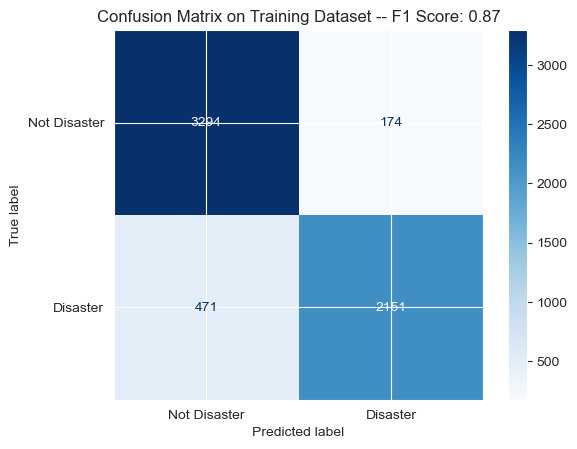

In [46]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step


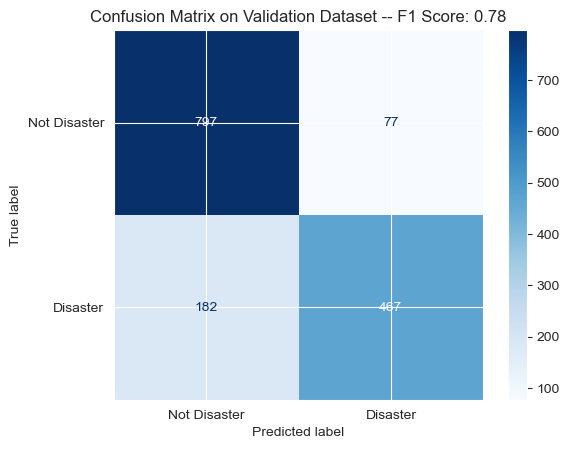

In [47]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [48]:
sample_submission = pd.read_csv("../Data/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [49]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step


In [50]:
sample_submission.to_csv("submission-swr_ep3.csv", index=False)